***
<img align="right" src="images/Logo_Università_Padova.png" alt="Drawing" style="width: 500px"/>
<img align="right" src="images/Logo_Physics_of_Data.jpg" alt="Drawing" style="width: 223px"/>

# AS4PA Final Project
# Study of rare $\Lambda_b^0$ decay using multivariate analysis techniques

### Authors
* [**Ardino Rocco**](https://github.com/RoccoA97) (University of Padua, Physics of Data)
* [**Valente Alessandro**](https://github.com/mastrovalentz) (University of Padua, Physics of Data)





In this notebook is reported most of the code used in the work, the result are explained and discussed in the final report [**here**](https://github.com/mastrovalentz/Adv_Stat_Final_Project/blob/master/presentation/presentation.ipynb)

In [1]:
library(keras)
library(repr)

## DataSet load and data preparation
The datasets are loaded from the data directory which is not included in the github repository due to its dimension

In [2]:
data.bkg  <- read.csv("../data/P_LHCB_LambdaB/background.csv")
data.sig  <- read.csv("../data/P_LHCB_LambdaB/MC_signal.csv")
data.lhcb <- read.csv("../data/P_LHCB_LambdaB/data_lhcb.csv")

After loading the cutted datasets are prepared alongside with the x and y datasets for test and training procedure

In [3]:
#cutted lhcb data
data.cutted.lhcb <-  data.lhcb %>% dplyr::filter( (Lambda_b0_MM_F > 5550 &  Lambda_b0_MM_F < 5680 ) |  DeltaM_F < 360)


In [4]:
#test data set
sel_features <- c(3, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18)
nt_bkg <- 400; nt_sig <- 400

x_test_bkg  <- as.matrix(data.bkg[1:nt_bkg, sel_features])
x_test_sig  <- as.matrix(data.sig[1:nt_sig, sel_features])

y_test_bkg  <- as.vector(matrix(0, nrow=nt_bkg, ncol=1))
y_test_sig  <- as.vector(matrix(1, nrow=nt_sig, ncol=1))

x_test  <- rbind(x_test_bkg  , x_test_sig  )
y_test  <-     c(y_test_bkg  , y_test_sig  )

x_test  <- scale(x_test )

shuffle_test  <- sample(nrow(x_test ))
x_test  <- x_test [shuffle_test,]
y_test  <- y_test [shuffle_test] 


In [5]:
#train data set with function for data reception
x_train_bkg_full <- as.matrix(data.bkg[-1:-nt_bkg, sel_features])
x_train_sig_full <- as.matrix(data.sig[-1:-nt_sig, sel_features])

y_train_bkg_full <- as.vector(matrix(0, nrow=nrow(x_train_bkg_full), ncol=1))
y_train_sig_full <- as.vector(matrix(1, nrow=nrow(x_train_sig_full), ncol=1))

get_train_data <- function(n_bkg, n_sig=1090 ){
    x_bkg <- x_train_bkg_full[1:n_bkg, ]
    x_sig <- x_train_sig_full[1:n_sig, ]
    x_t   <- rbind(x_bkg, x_sig)
    y_t   <- c(y_train_bkg_full[1:n_bkg], y_train_sig_full[1:n_sig])
    sffl  <- sample(nrow(x_t))
    
    x_t   <- x_t[sffl,]
    x_t   <- scale(x_t)
    y_t   <- y_t[sffl] 
    return (list(x_train=x_t, y_train=y_t))
}


In [6]:
#dataset for the final predictions

# lhcb data
x_lhcb     <- as.matrix(       data.lhcb[, sel_features])
x_cut_lhcb <- as.matrix(data.cutted.lhcb[, sel_features])

x_lhcb     <- scale(x_lhcb)
x_cut_lhcb <- scale(x_cut_lhcb)

## Data Set visualization

In order to visualize the most important features we defined two function with the purpose of data visualization

In [7]:
plot_all_cutting_features <- function(repr_plot_width=12, repr_plot_height=4, repr_plot_res=250) {

    ID_04 <- TRUE
    ID_15 <- TRUE
    breaks_ID_04_bkg <- 100;		breaks_ID_04_sig <- 100;		breaks_ID_04_lhcb <- 100;
    breaks_ID_15_bkg <- 100;		breaks_ID_15_sig <-  50;		breaks_ID_15_lhcb <- 100;
    if (ID_04) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)
        hist(data.bkg$Lambda_b0_MM_F,
             breaks=breaks_ID_04_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste(Lambda[b]^0, " Mass", " [MeV/c^2]")), main="Background Dataset"); box()
        hist(data.sig$Lambda_b0_MM_F,
             breaks=breaks_ID_04_sig, probability=TRUE, col="navy",
             xlab=expression(paste(Lambda[b]^0, " Mass", " [MeV/c^2]")), main="Signal Dataset");     box()
        hist(data.lhcb$Lambda_b0_MM_F,
             breaks=breaks_ID_04_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste(Lambda[b]^0, " Mass", " [MeV/c^2]")), main="LHCb Dataset");       box()
    }



    if (ID_15) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)
        hist(data.bkg$DeltaM_F,
             breaks=breaks_ID_15_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste(Delta, "M", " [MeV/c^2]")), main="Background Dataset"); box()
        hist(data.sig$DeltaM_F,
             breaks=breaks_ID_15_sig, probability=TRUE, col="navy",
             xlab=expression(paste(Delta, "M", " [MeV/c^2]")), main="Signal Dataset");     box()
        hist(data.lhcb$DeltaM_F,
             breaks=breaks_ID_15_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste(Delta, "M", " [MeV/c^2]")), main="LHCb Dataset");       box()
    }

}

plot_all_input_features <- function(repr_plot_width=12, repr_plot_height=4, repr_plot_res=250) {

    ID_03 <- TRUE
    ID_06 <- TRUE
    ID_07 <- TRUE
    ID_08 <- TRUE
    ID_09 <- TRUE
    ID_10 <- TRUE
    ID_11 <- TRUE
    ID_12 <- TRUE
    ID_14 <- TRUE
    ID_17 <- TRUE
    ID_18 <- TRUE

    breaks_ID_03_bkg <-  30;   breaks_ID_03_sig <-  30;    breaks_ID_03_lhcb <-  30;
    breaks_ID_06_bkg <- 100;   breaks_ID_06_sig <- 100;    breaks_ID_06_lhcb <-  25;
    breaks_ID_07_bkg <- 100;   breaks_ID_07_sig <-  25;    breaks_ID_07_lhcb <- 100;
    breaks_ID_08_bkg <- 100;   breaks_ID_08_sig <-  25;    breaks_ID_08_lhcb <- 100;
    breaks_ID_09_bkg <- 100;   breaks_ID_09_sig <-  25;    breaks_ID_09_lhcb <- 100;
    breaks_ID_10_bkg <- 100;   breaks_ID_10_sig <-  25;    breaks_ID_10_lhcb <- 100;
    breaks_ID_11_bkg <- 100;   breaks_ID_11_sig <-  25;    breaks_ID_11_lhcb <- 100;
    breaks_ID_12_bkg <- 100;   breaks_ID_12_sig <-  25;    breaks_ID_12_lhcb <- 100;
    breaks_ID_14_bkg <-  25;   breaks_ID_14_sig <-  25;    breaks_ID_14_lhcb <-  25;
    breaks_ID_17_bkg <- 100;   breaks_ID_17_sig <-  25;    breaks_ID_17_lhcb <- 100;
    breaks_ID_18_bkg <- 100;   breaks_ID_18_sig <-  25;    breaks_ID_18_lhcb <- 100;


    if (ID_03) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)
        hist(data.bkg$Lambda_c_MM_F,
             breaks=breaks_ID_03_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste(Lambda[c]^'+', " Mass [MeV/c^2]")), main="Background Dataset"); box()
        hist(data.sig$Lambda_c_MM_F,
             breaks=breaks_ID_03_sig, probability=TRUE, col="navy",
             xlab=expression(paste(Lambda[c]^'+', " Mass [MeV/c^2]")), main="Signal Dataset");     box()
        hist(data.lhcb$Lambda_c_MM_F,
             breaks=breaks_ID_03_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste(Lambda[c]^'+', " Mass [MeV/c^2]")), main="LHCb Dataset");       box()
    }



    if (ID_06) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)

        hist(data.bkg$lcZDecLSigma_F[data.bkg$lcZDecLSigma_F<30 & data.bkg$lcZDecLSigma_F>-5],
             breaks=breaks_ID_06_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste(Lambda[c]^"+", " z decay length over error")), main="Background Dataset"); box()

        hist(data.sig$lcZDecLSigma_F[data.sig$lcZDecLSigma_F<30 & data.sig$lcZDecLSigma_F>-5],
             breaks=breaks_ID_06_sig, probability=TRUE, col="navy",
             xlab=expression(paste(Lambda[c]^"+", " z decay length over error")), main="Signal Dataset");     box()

        hist(data.lhcb$lcZDecLSigma_F[data.lhcb$lcZDecLSigma_F<30 & data.lhcb$lcZDecLSigma_F>-5],
             breaks=breaks_ID_06_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste(Lambda[c]^"+", " z decay length over error")), main="LHCb Dataset");       box()
    }



    if (ID_07) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)

        hist(data.bkg$lcstarZDecLSigma_F,
             breaks=breaks_ID_07_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste(Lambda[c]^"+*", " z decay length over error")), main="Background Dataset"); box()

        hist(data.sig$lcstarZDecLSigma_F,
             breaks=breaks_ID_07_sig, probability=TRUE, col="navy",
             xlab=expression(paste(Lambda[c]^"+*", " z decay length over error")), main="Signal Dataset");     box()

        hist(data.lhcb$lcstarZDecLSigma_F,
             breaks=breaks_ID_07_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste(Lambda[c]^"+*", " z decay length over error")), main="LHCb Dataset");       box()
    }



    if (ID_08) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)

        hist(data.bkg$lcDecTime_F[data.bkg$lcDecTime_F<1 & data.bkg$lcDecTime_F>-1],
             breaks=breaks_ID_08_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste({t^"decay"}[Lambda[c]], " [ps]")), main="Background Dataset"); box()

        hist(data.sig$lcDecTime_F[data.sig$lcDecTime_F<1 & data.sig$lcDecTime_F>-1],
             breaks=breaks_ID_08_sig, probability=TRUE, col="navy",
             xlab=expression(paste({t^"decay"}[Lambda[c]], " [ps]")), main="Signal Dataset");     box()

        hist(data.lhcb$lcDecTime_F[data.lhcb$lcDecTime_F<1 & data.lhcb$lcDecTime_F>-1],
             breaks=breaks_ID_08_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste({t^"decay"}[Lambda[c]], " [ps]")), main="LHCb Dataset");       box()
    }



    if (ID_09) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)

        hist(data.bkg$lcstarDecTime_F[data.bkg$lcstarDecTime_F<1 & data.bkg$lcstarDecTime_F>-1],
             breaks=breaks_ID_09_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste({t^"decay"}[Lambda[c]^"*"], " [ps]")), main="Background Dataset"); box()

        hist(data.sig$lcstarDecTime_F[data.sig$lcstarDecTime_F<1 & data.sig$lcstarDecTime_F>-1],
             breaks=breaks_ID_09_sig, probability=TRUE, col="navy",
             xlab=expression(paste({t^"decay"}[Lambda[c]^"*"], " [ps]")), main="Signal Dataset");     box()

        hist(data.lhcb$lcstarDecTime_F[data.lhcb$lcstarDecTime_F<1 & data.lhcb$lcstarDecTime_F>-1],
             breaks=breaks_ID_09_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste({t^"decay"}[Lambda[c]^"*"], " [ps]")), main="LHCb Dataset");       box()
    }



    if (ID_10) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)

        hist(data.bkg$lbDecTime_F[data.bkg$lbDecTime_F<10],
             breaks=breaks_ID_10_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste({t^"decay"}[Lambda[b]], " [ps]")), main="Background Dataset"); box()

        hist(data.sig$lbDecTime_F[data.sig$lbDecTime_F<10],
             breaks=breaks_ID_10_sig, probability=TRUE, col="navy",
             xlab=expression(paste({t^"decay"}[Lambda[b]], " [ps]")), main="Signal Dataset");     box()

        hist(data.lhcb$lbDecTime_F[data.lhcb$lbDecTime_F<10],
             breaks=breaks_ID_10_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste({t^"decay"}[Lambda[b]], " [ps]")), main="LHCb Dataset");       box()
    }



    if (ID_11) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)

        hist(data.bkg$lcDecVerChi2_F,
             breaks=breaks_ID_11_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste("Probability of ", Lambda[c]^"+", " decay vertex")), main="Background Dataset"); box()

        hist(data.sig$lcDecVerChi2_F,
             breaks=breaks_ID_11_sig, probability=TRUE, col="navy",
             xlab=expression(paste("Probability of ", Lambda[c]^"+", " decay vertex")), main="Signal Dataset");     box()

        hist(data.lhcb$lcDecVerChi2_F,
             breaks=breaks_ID_11_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste("Probability of ", Lambda[c]^"+", " decay vertex")), main="LHCb Dataset");       box()
    }



    if (ID_12) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)
        hist(data.bkg$lcstarDecVerChi2_F,
             breaks=breaks_ID_12_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste("Probability of ", Lambda[c]^"+*", " decay vertex")), main="Background Dataset"); box()
        hist(data.sig$lcstarDecVerChi2_F,
             breaks=breaks_ID_12_sig, probability=TRUE, col="navy",
             xlab=expression(paste("Probability of ", Lambda[c]^"+*", " decay vertex")), main="Signal Dataset");     box()
        hist(data.lhcb$lcstarDecVerChi2_F,
             breaks=breaks_ID_12_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste("Probability of ", Lambda[c]^"+*", " decay vertex")), main="LHCb Dataset");       box()
        
   } 


    if (ID_14) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)
        hist(data.bkg$Lambda_b0_DIRA_OWNPV_F,
             breaks=breaks_ID_14_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste(Lambda[b]^"0", " DIRA of PV")), main="Background Dataset"); box()
        hist(data.sig$Lambda_b0_DIRA_OWNPV_F,
             breaks=breaks_ID_14_sig, probability=TRUE, col="navy",
             xlab=expression(paste(Lambda[b]^"0", " DIRA of PV")), main="Signal Dataset");     box()
        hist(data.lhcb$Lambda_b0_DIRA_OWNPV_F,
             breaks=breaks_ID_14_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste(Lambda[b]^"0", " DIRA of PV")), main="LHCb Dataset");       box()
        
    }


    if (ID_17) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)
        hist(data.bkg$pair0_3pi_F,
             breaks=breaks_ID_17_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste("Pair mass of pions 1", " [MeV/c^2]")), main="Background Dataset"); box()
        hist(data.sig$pair0_3pi_F,
             breaks=breaks_ID_17_sig, probability=TRUE, col="navy",
             xlab=expression(paste("Pair mass of pions 1", " [MeV/c^2]")), main="Signal Dataset");     box()
        hist(data.lhcb$pair0_3pi_F,
             breaks=breaks_ID_17_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste("Pair mass of pions 1", " [MeV/c^2]")), main="LHCb Dataset");       box()
        }



    if (ID_18) {
        par(mfrow=c(1,3))
        options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)

        hist(data.bkg$pair1_3pi_F,
             breaks=breaks_ID_18_bkg, probability=TRUE, col="firebrick3",
             xlab=expression(paste("Pair mass of pions 2", " [MeV/c^2]")), main="Background Dataset"); box()

        hist(data.sig$pair1_3pi_F,
             breaks=breaks_ID_18_sig, probability=TRUE, col="navy",
             xlab=expression(paste("Pair mass of pions 2", " [MeV/c^2]")), main="Signal Dataset");     box()

        hist(data.lhcb$pair1_3pi_F,
             breaks=breaks_ID_18_lhcb, probability=TRUE, col="darkgreen",
             xlab=expression(paste("Pair mass of pions 2", " [MeV/c^2]")), main="LHCb Dataset");       box()
    }

}




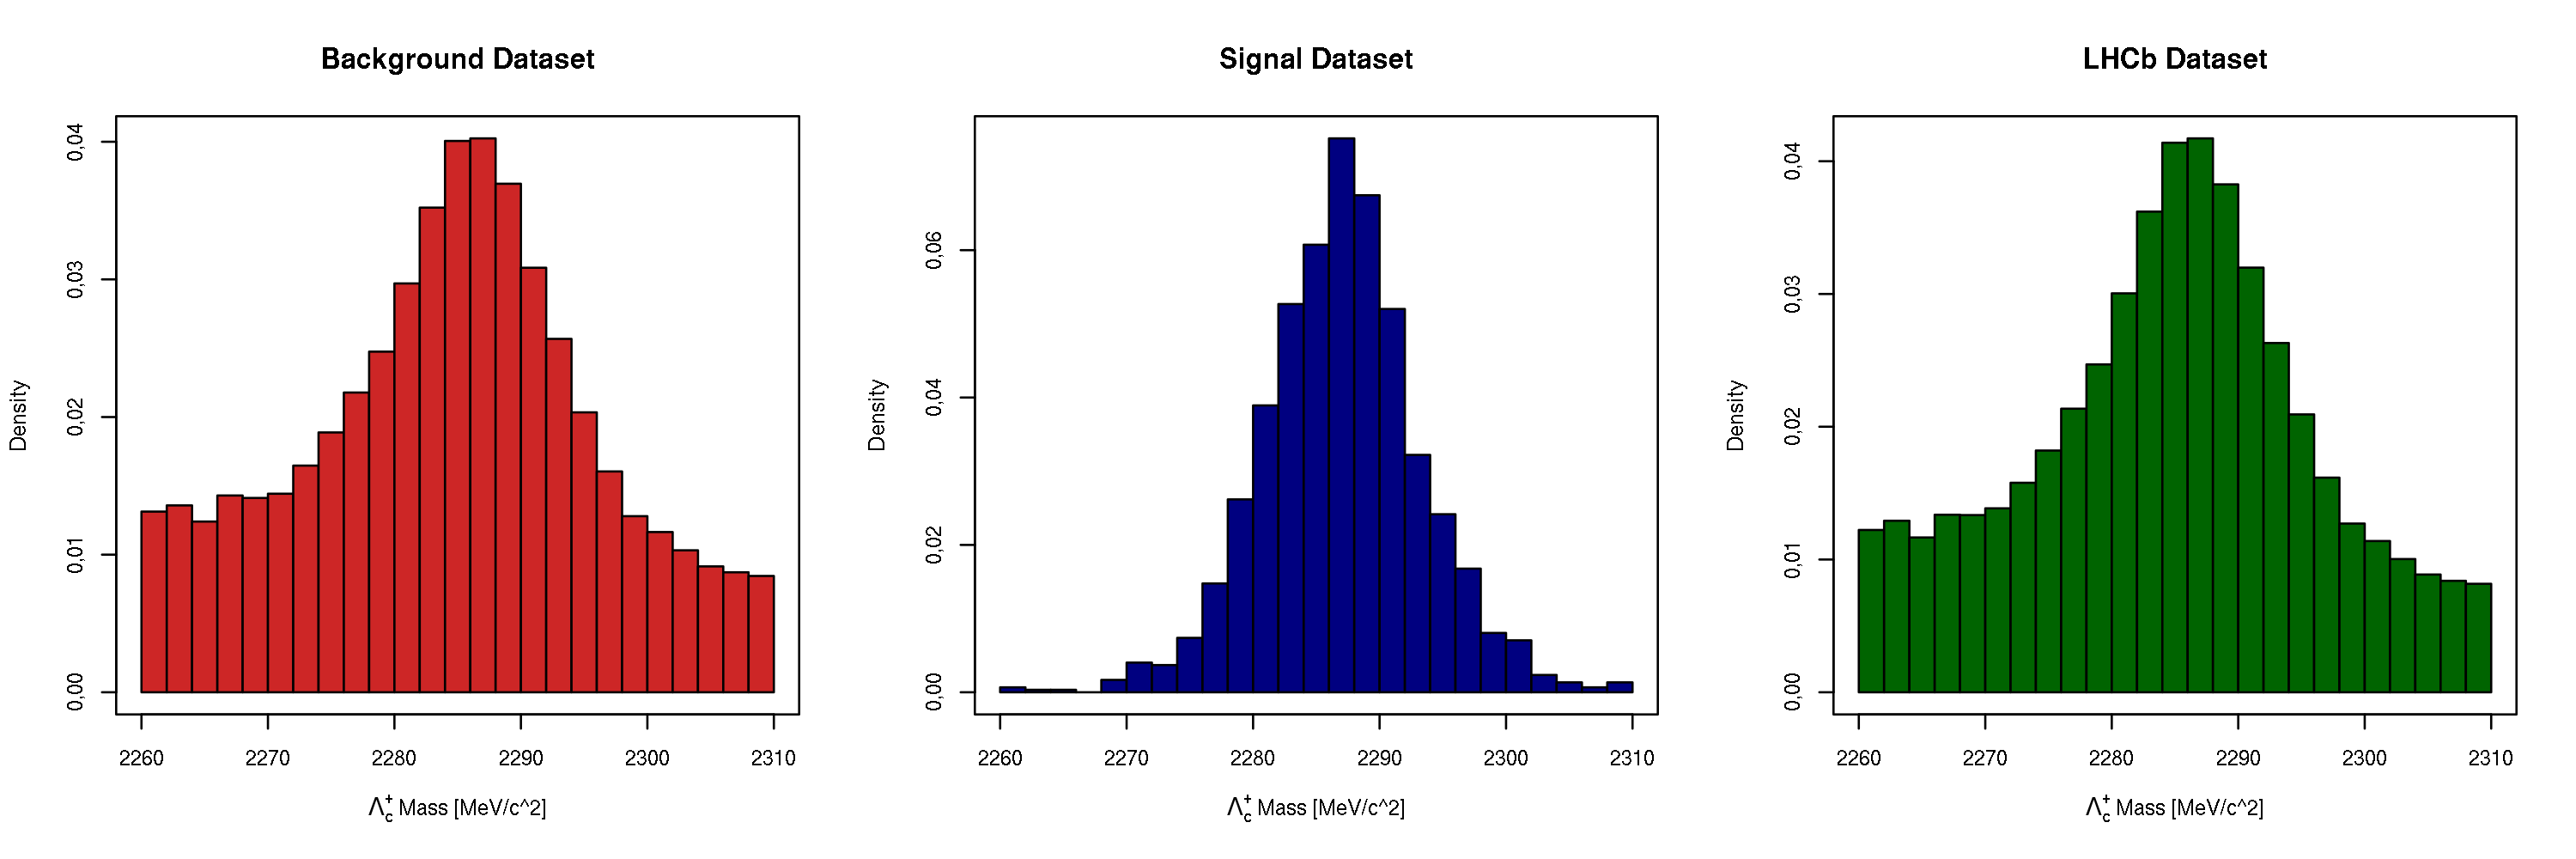

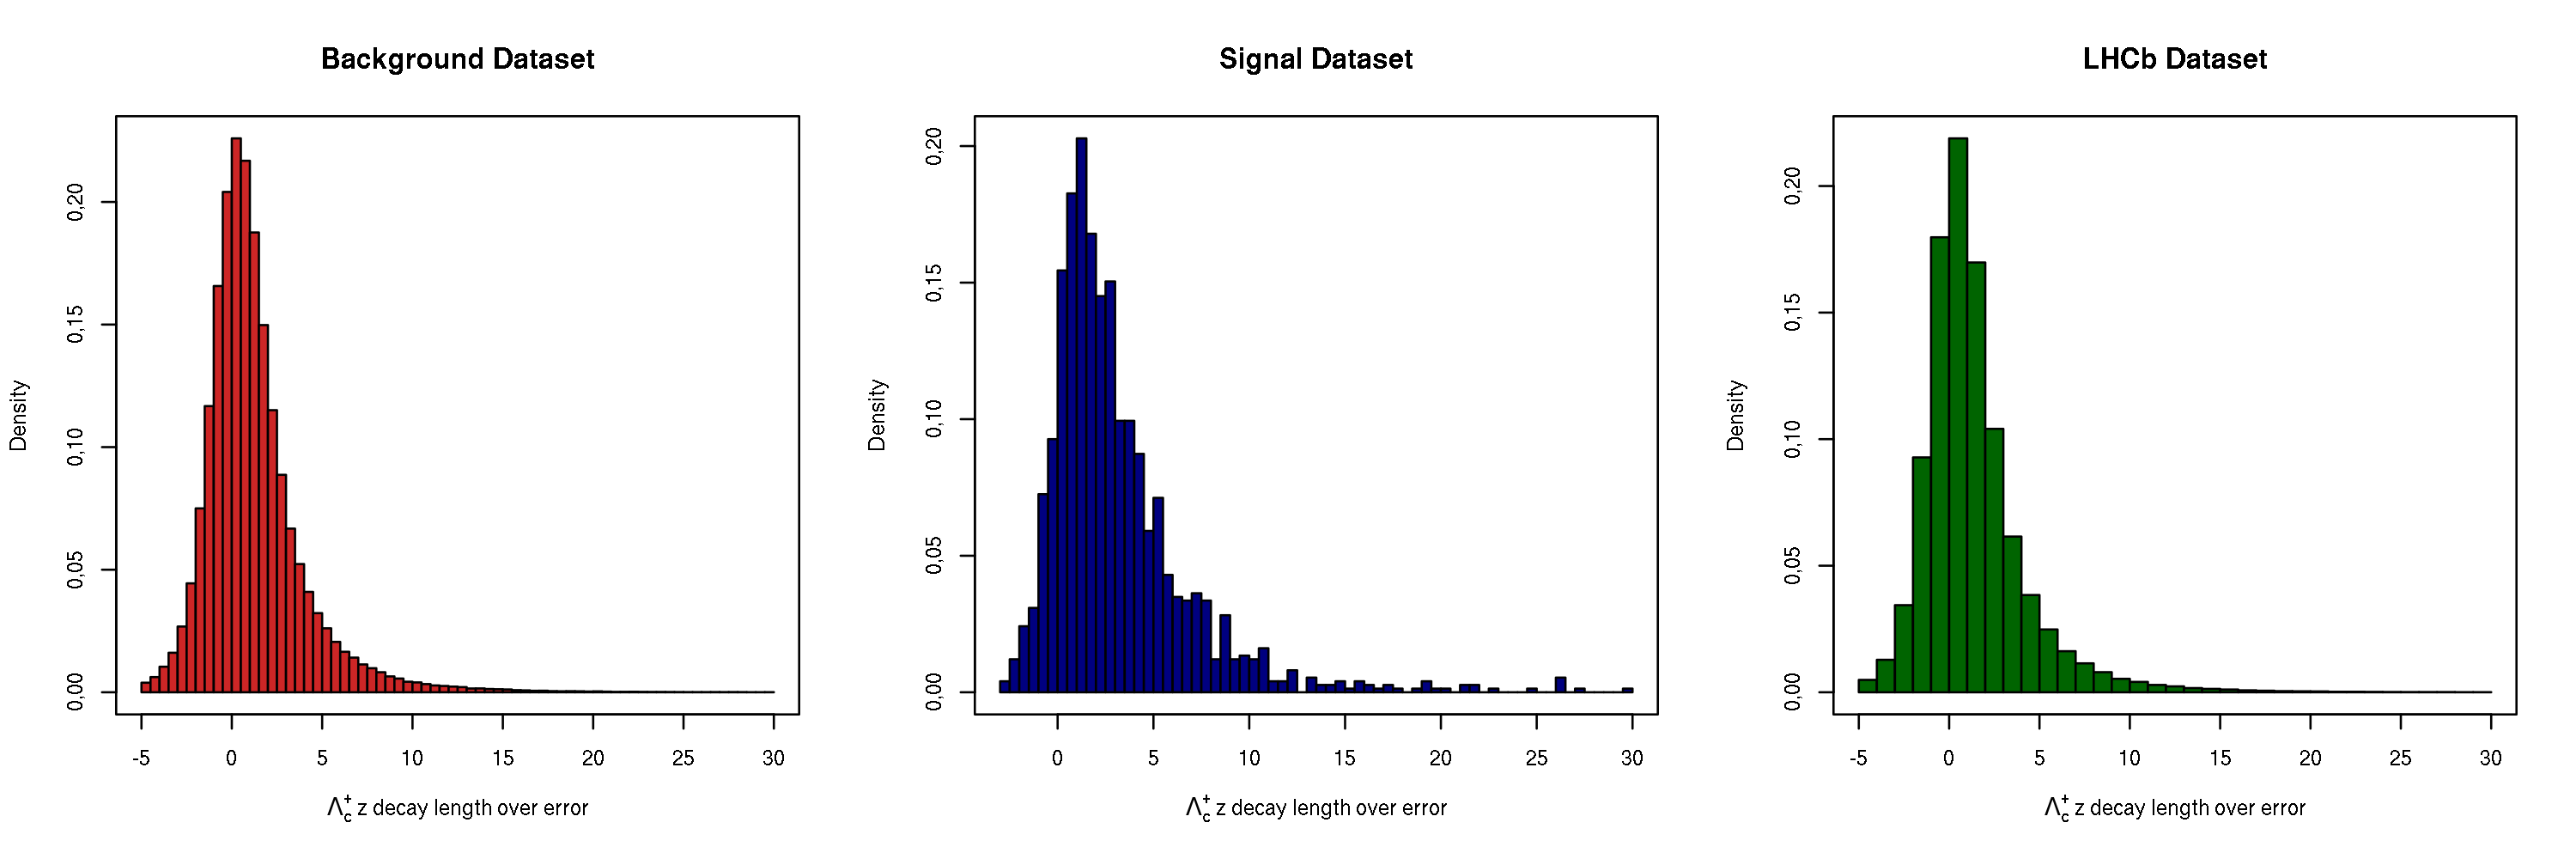

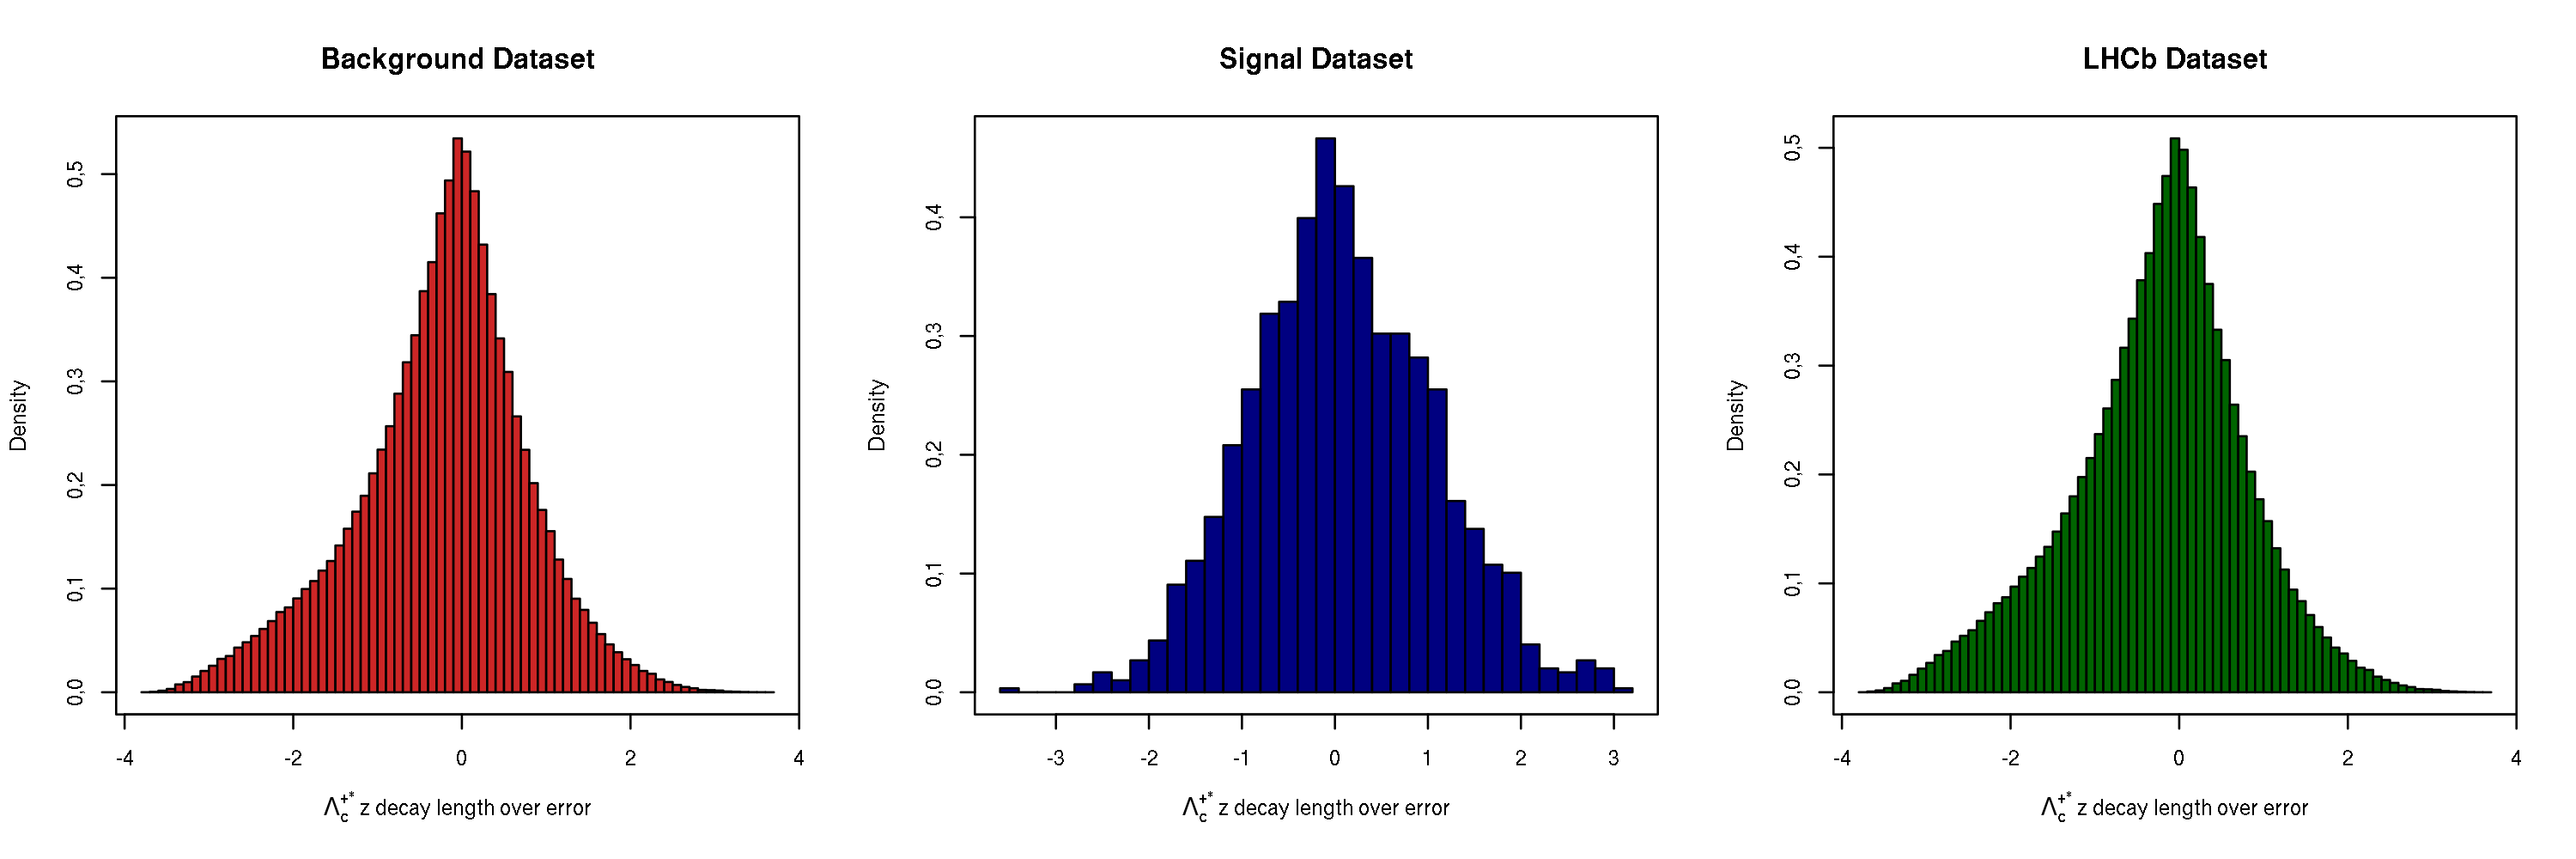

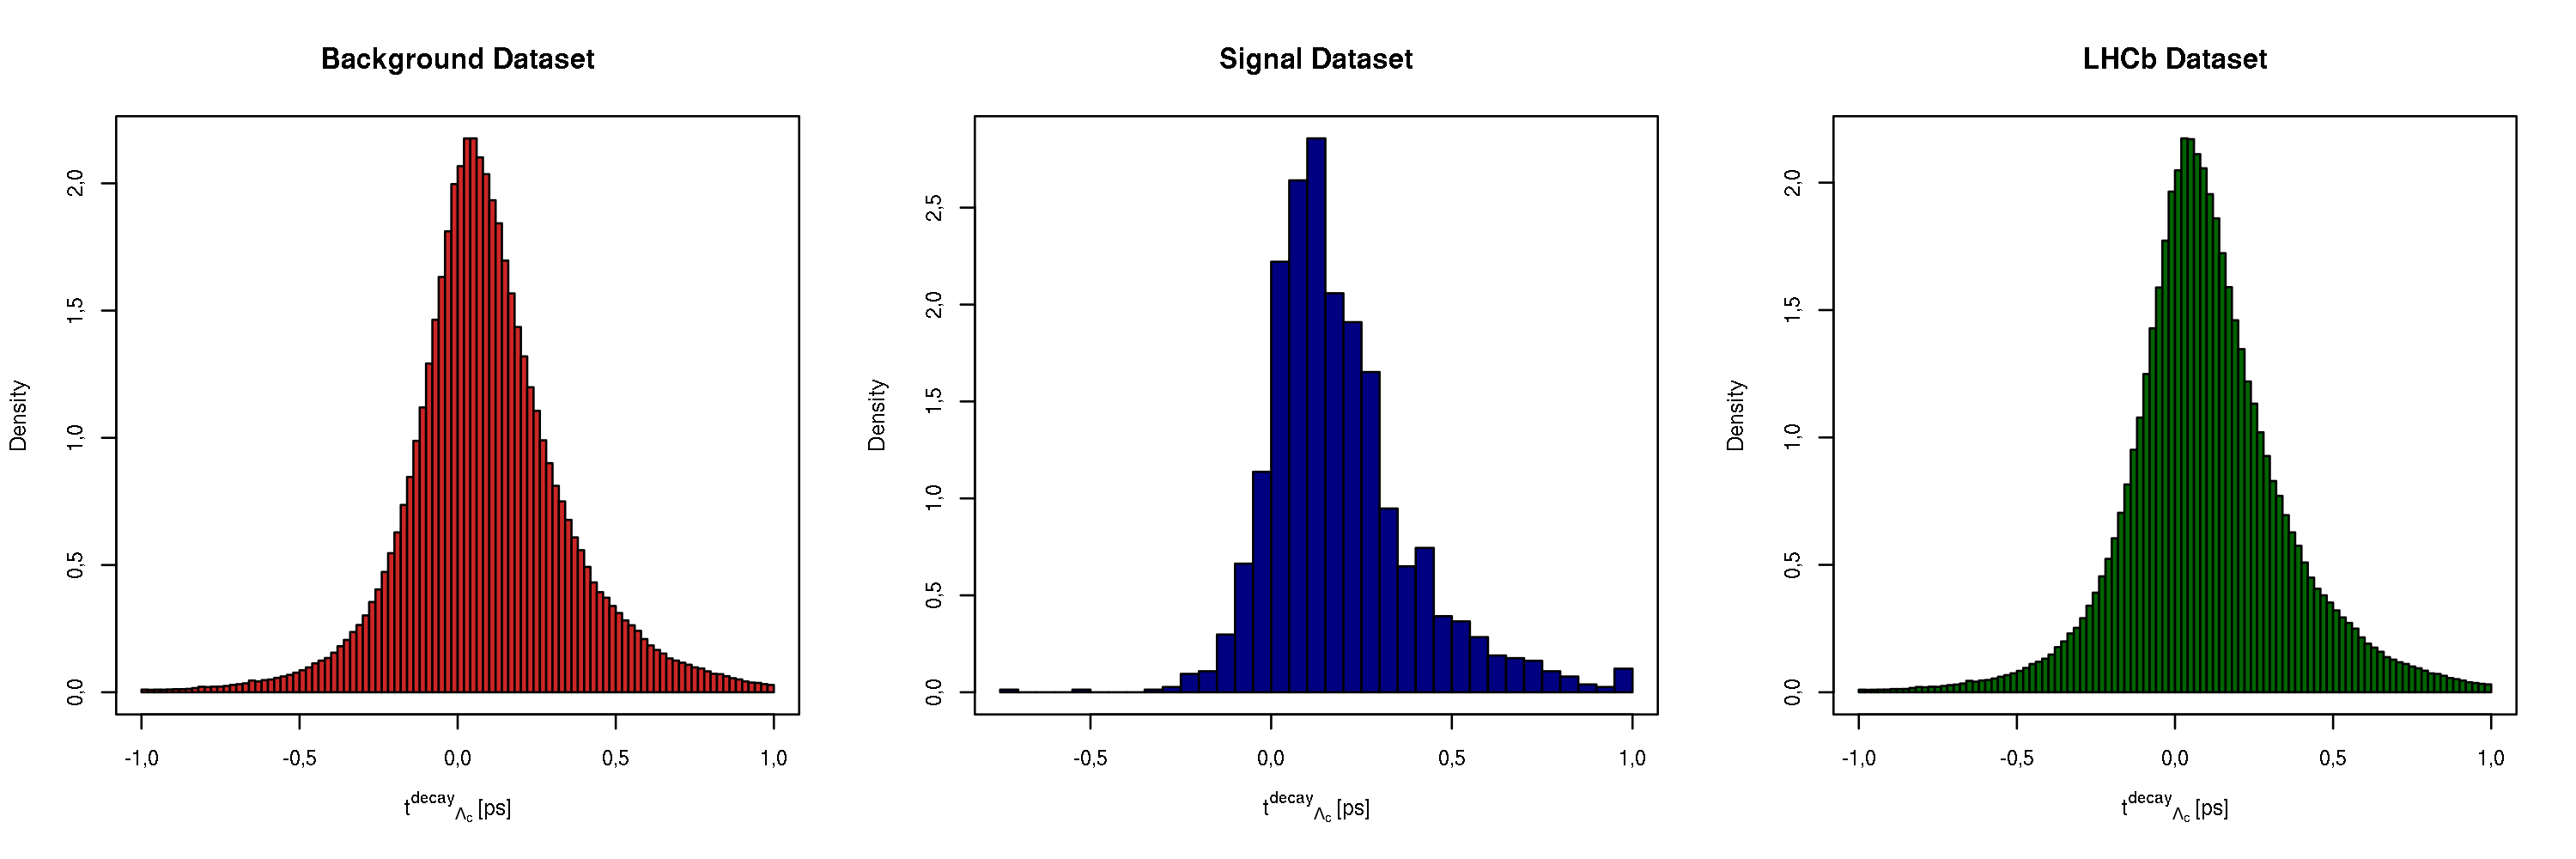

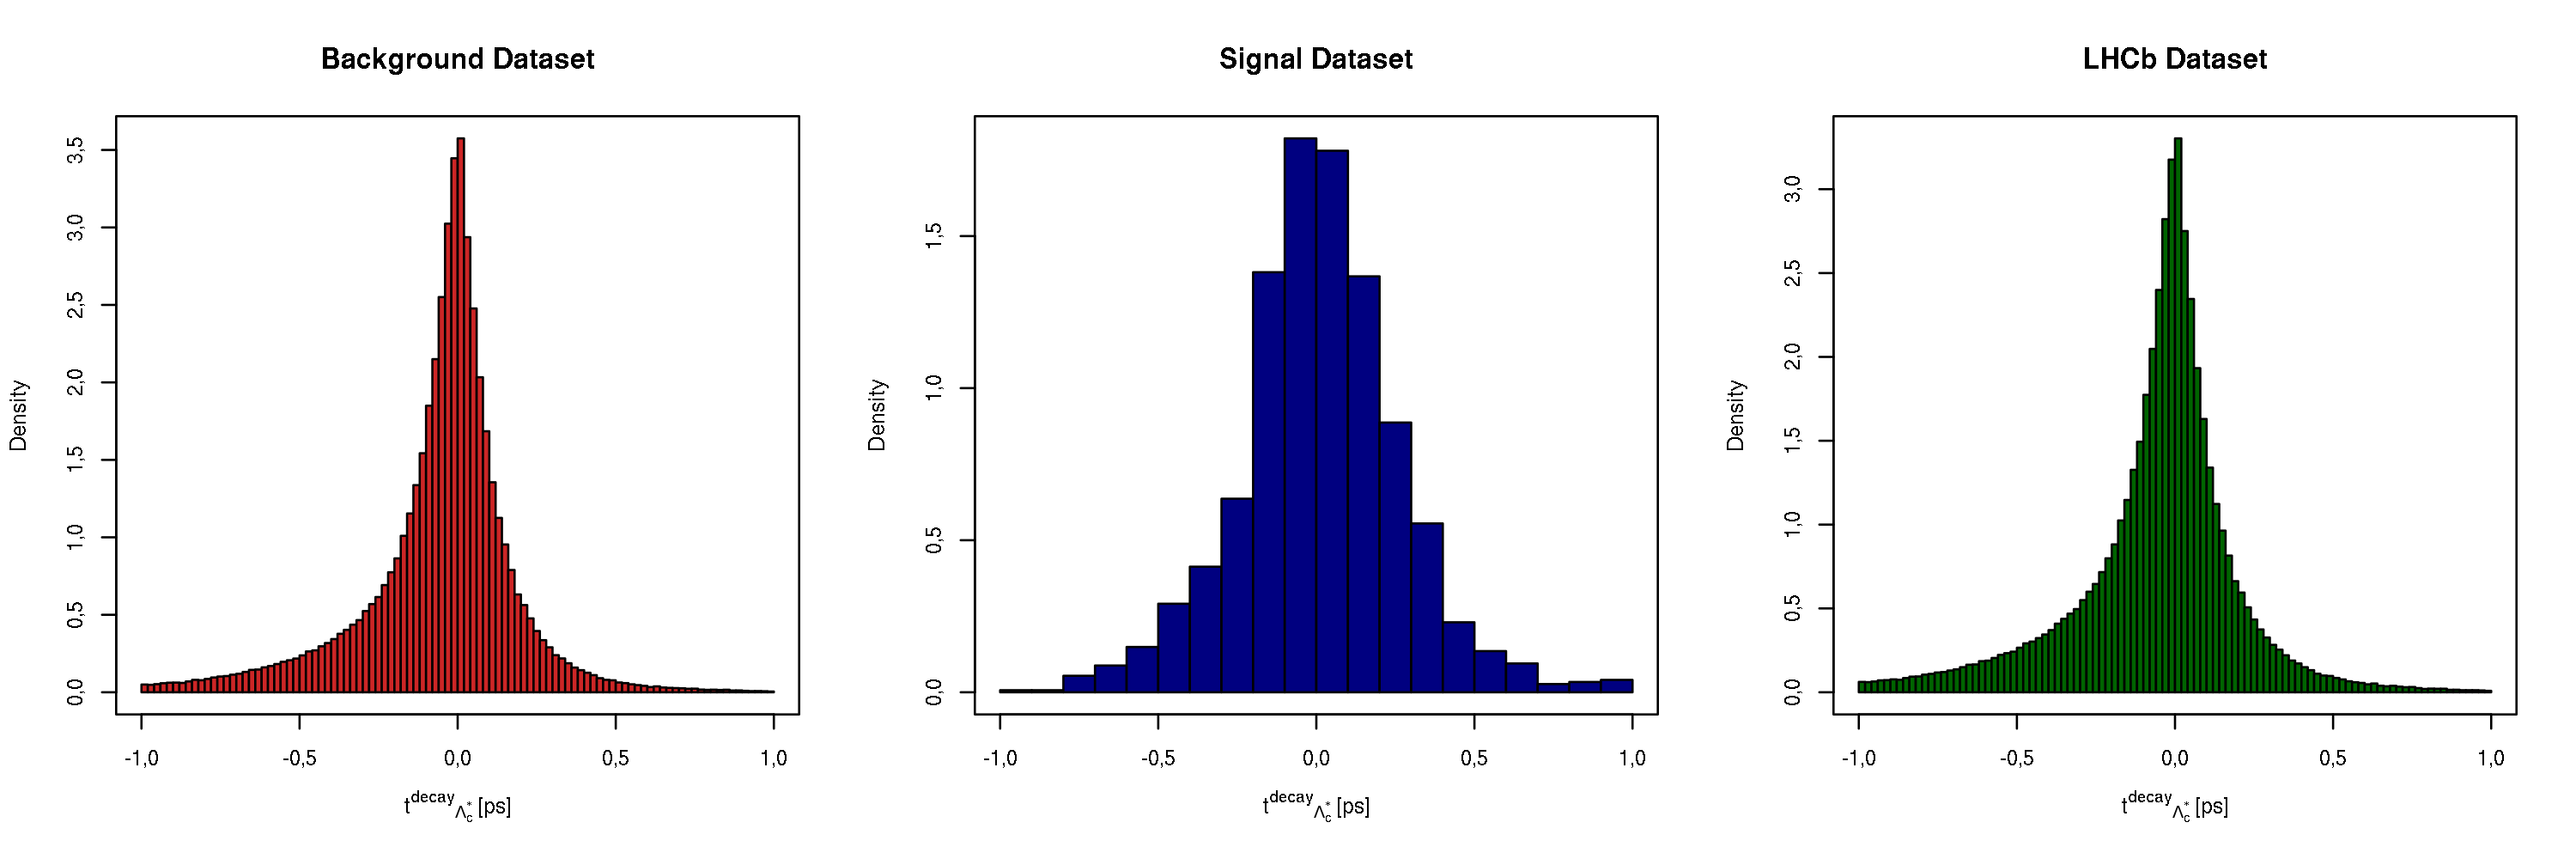

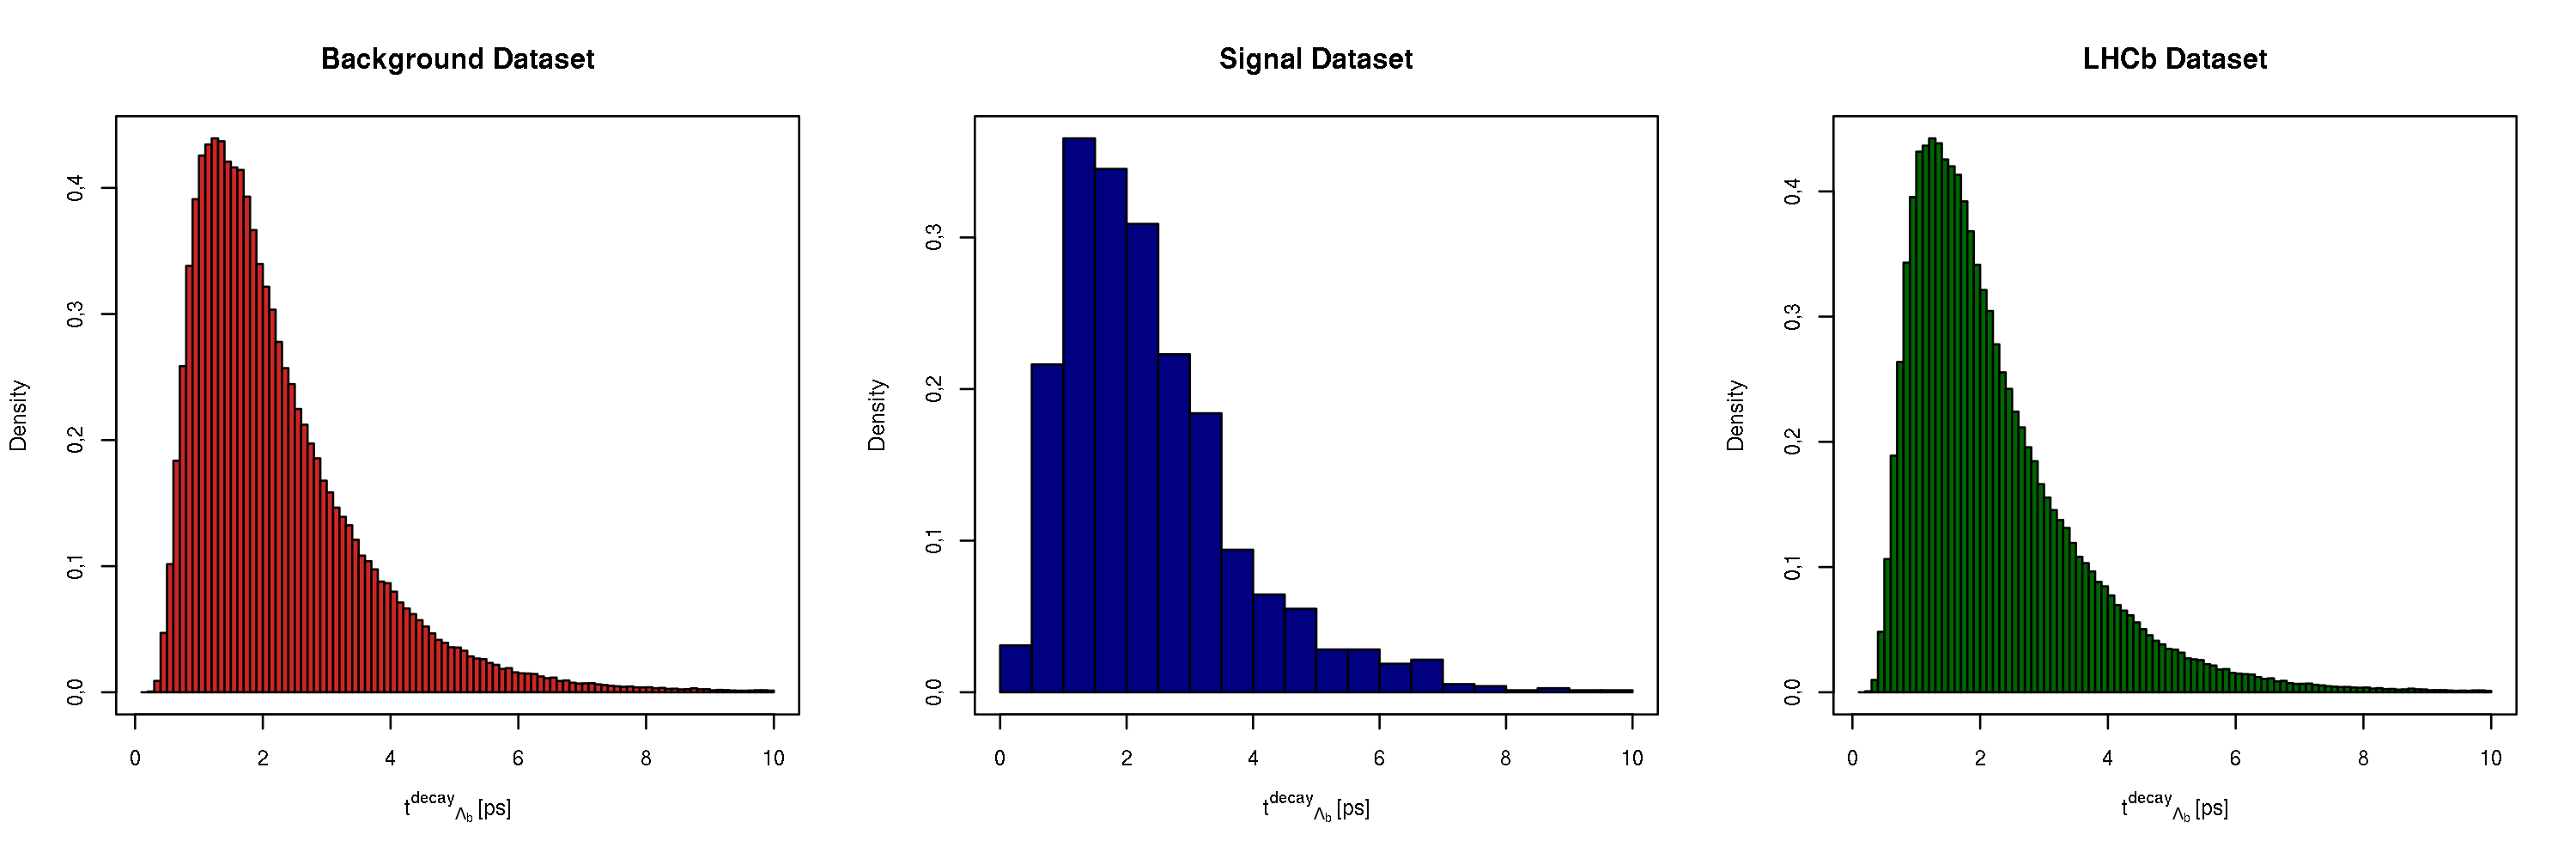

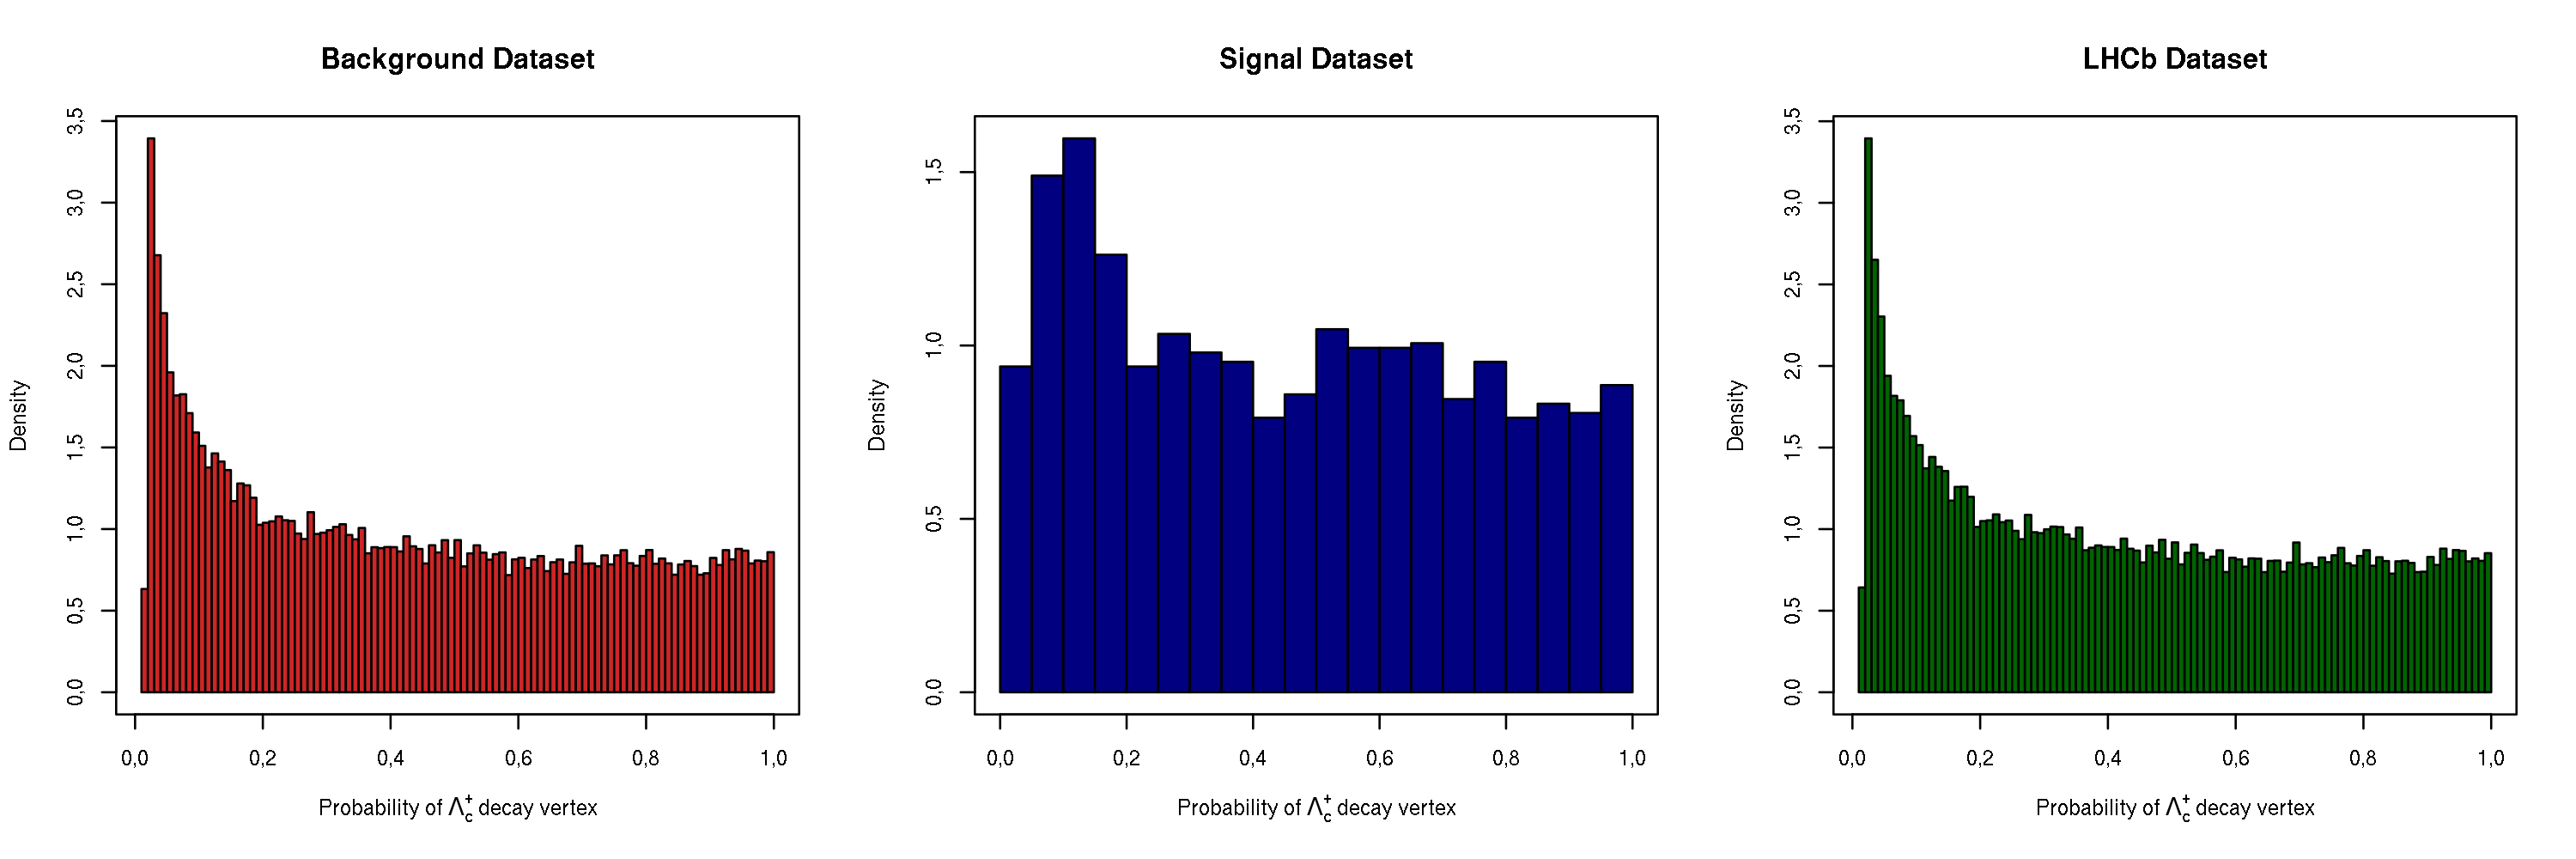

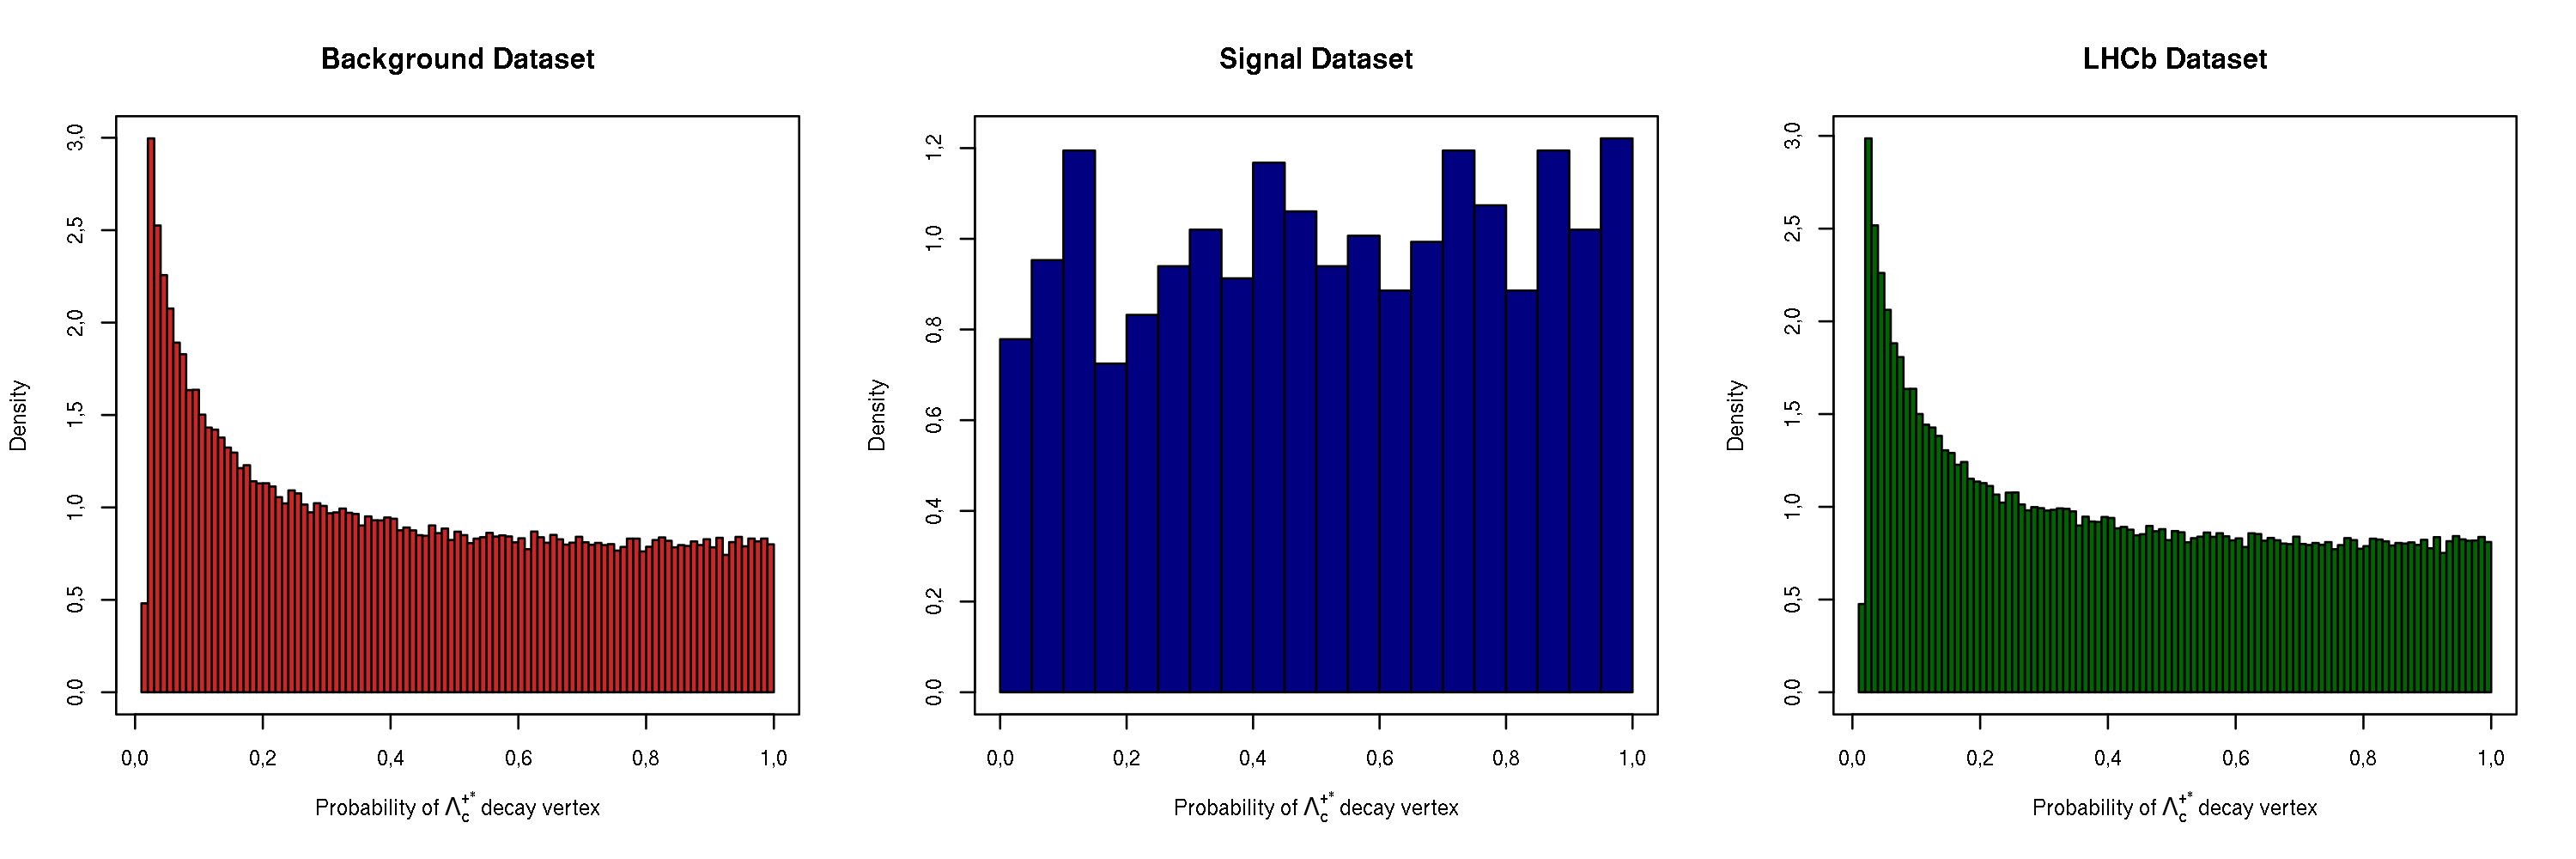

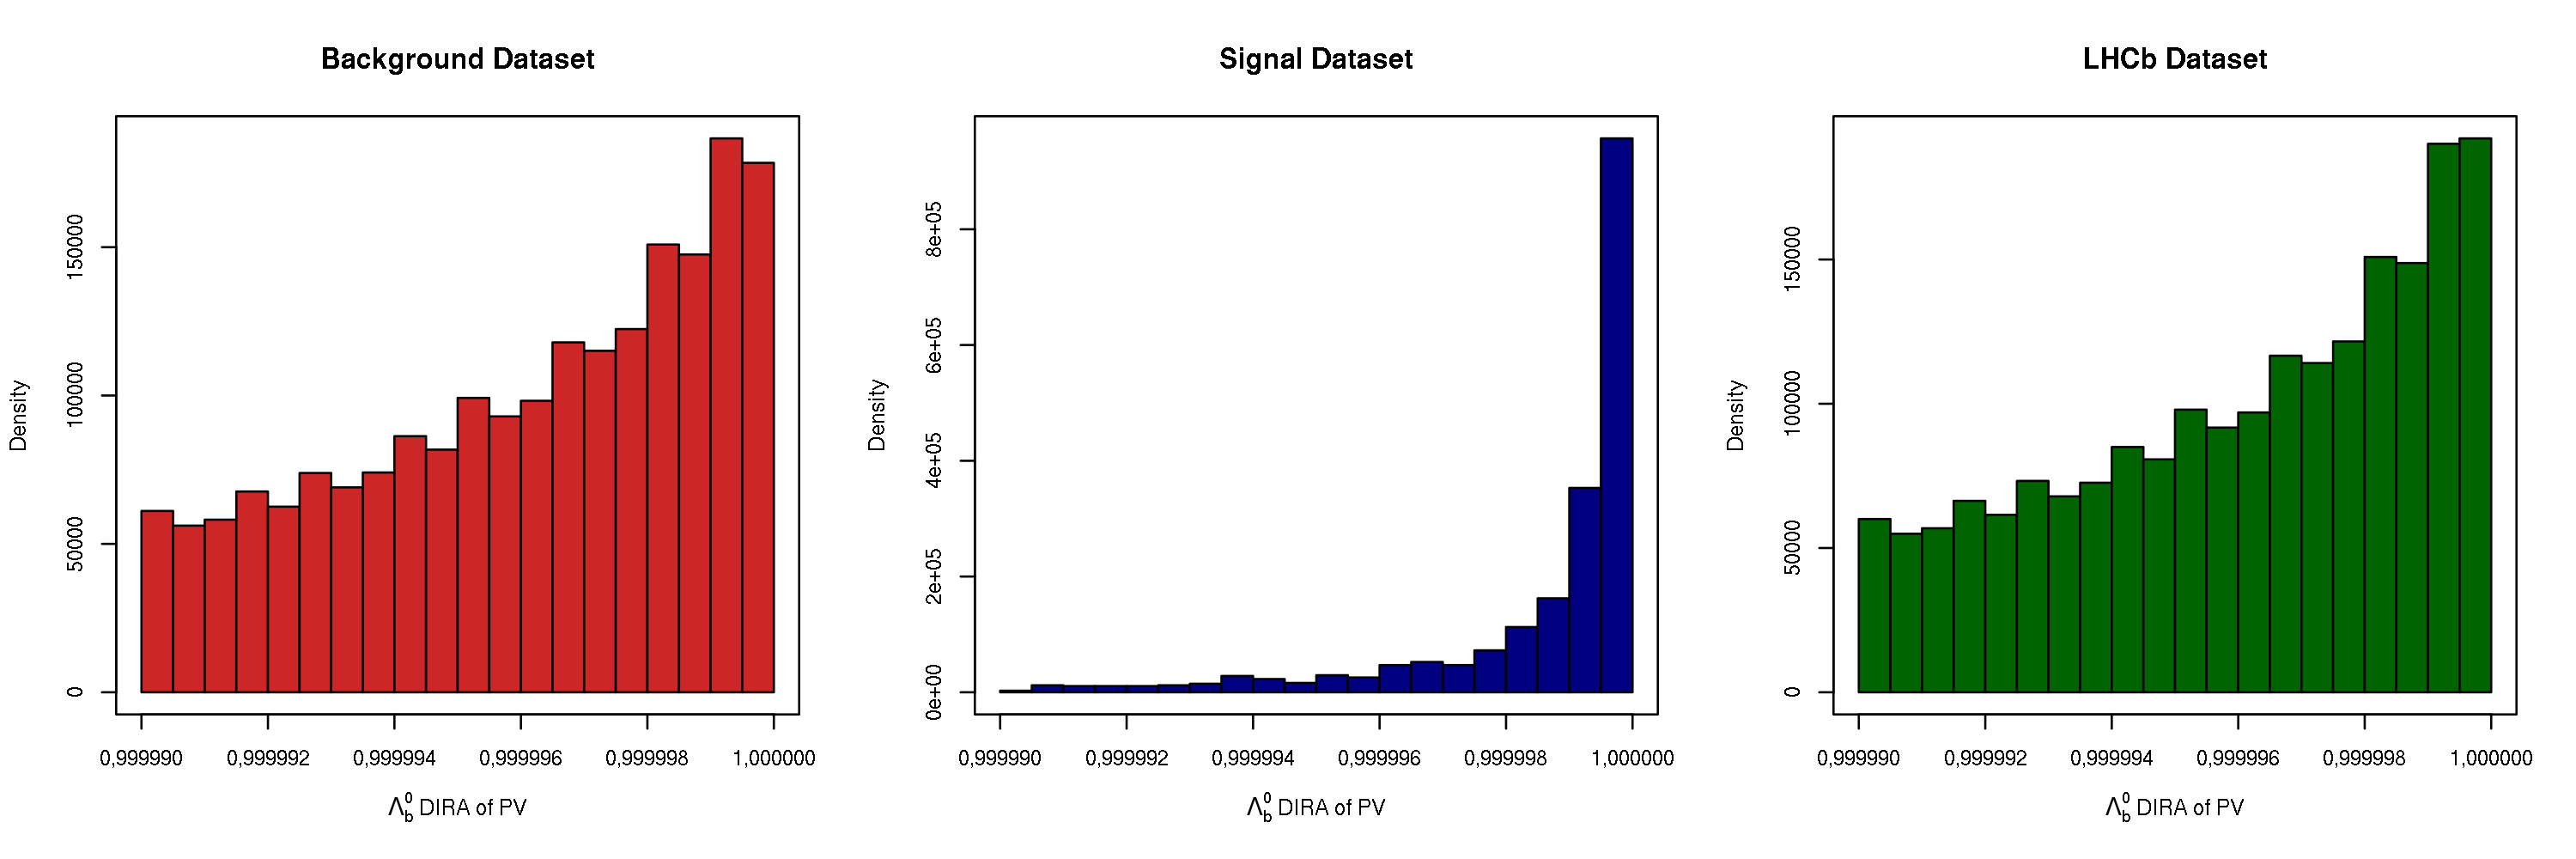

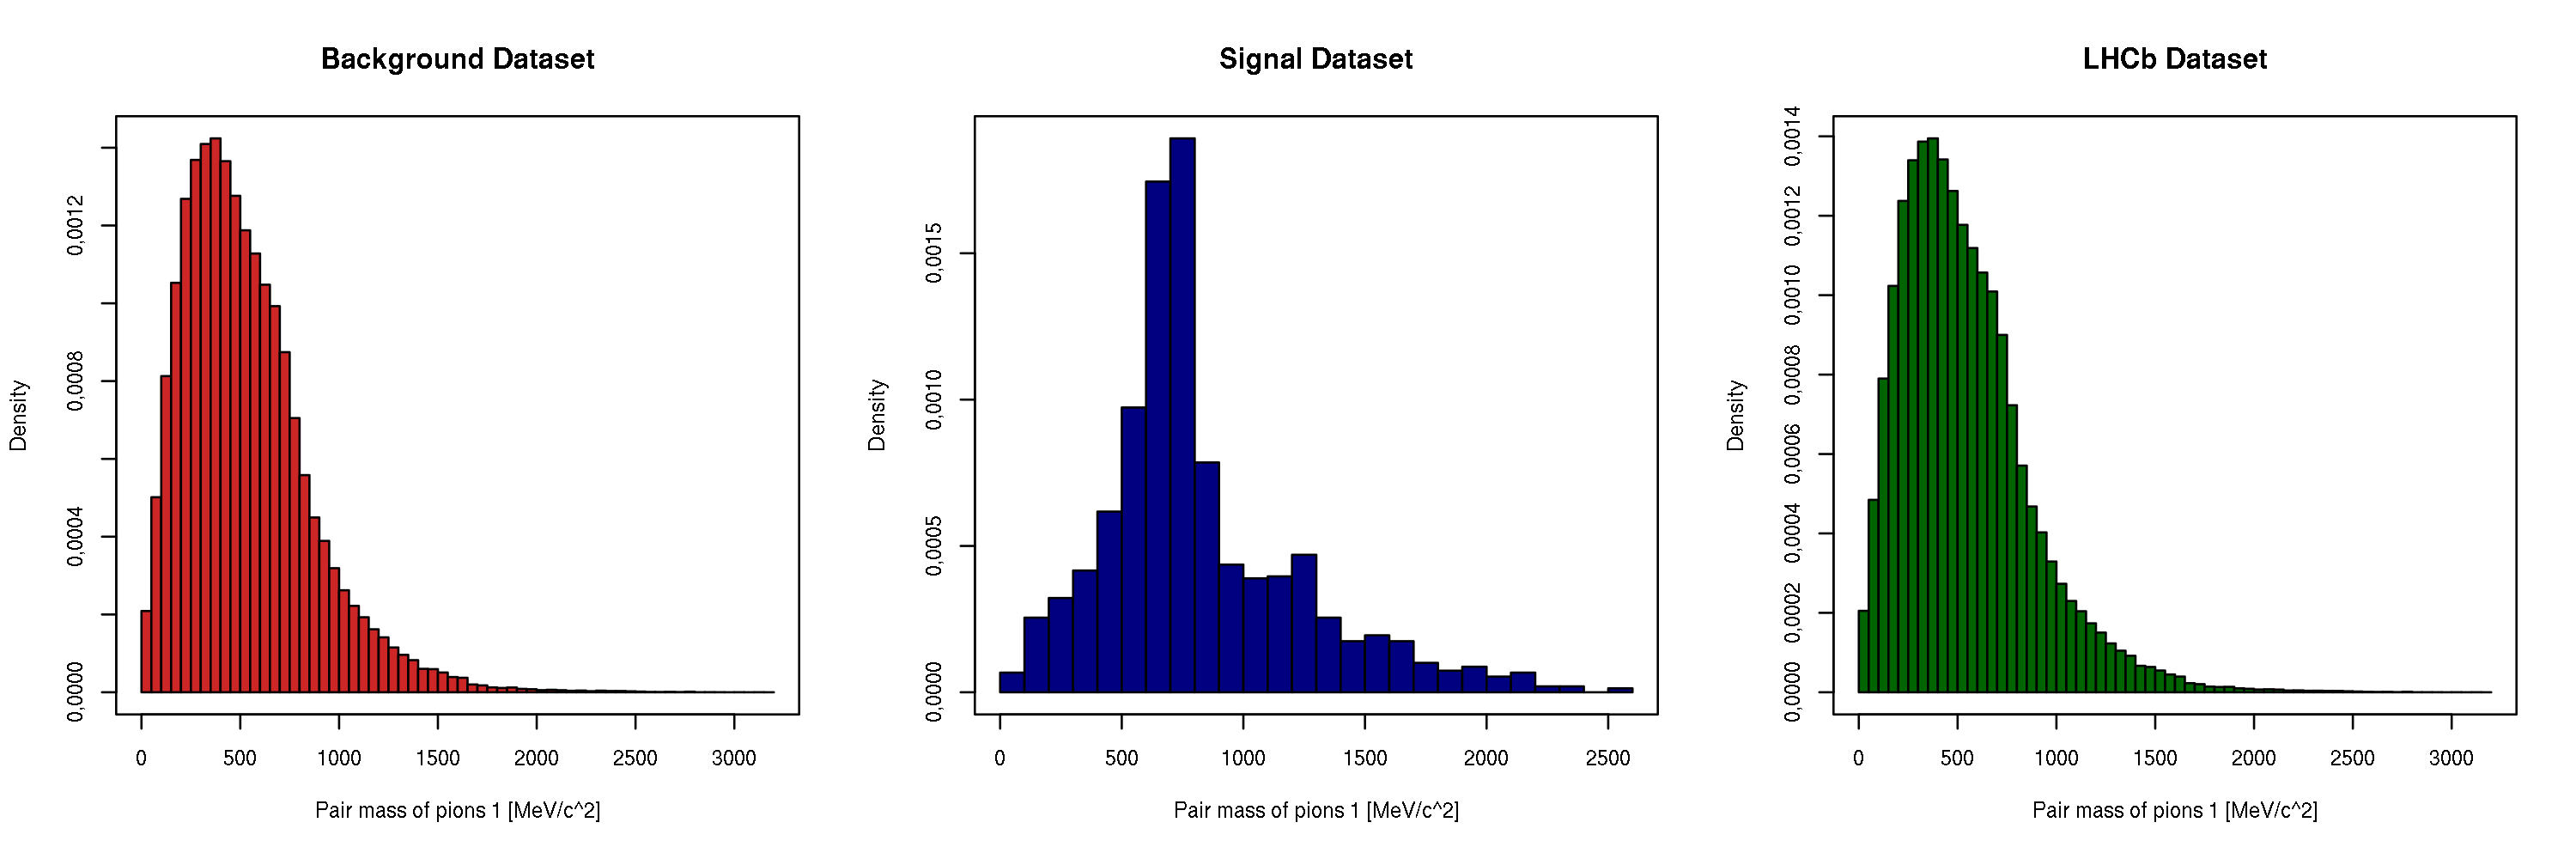

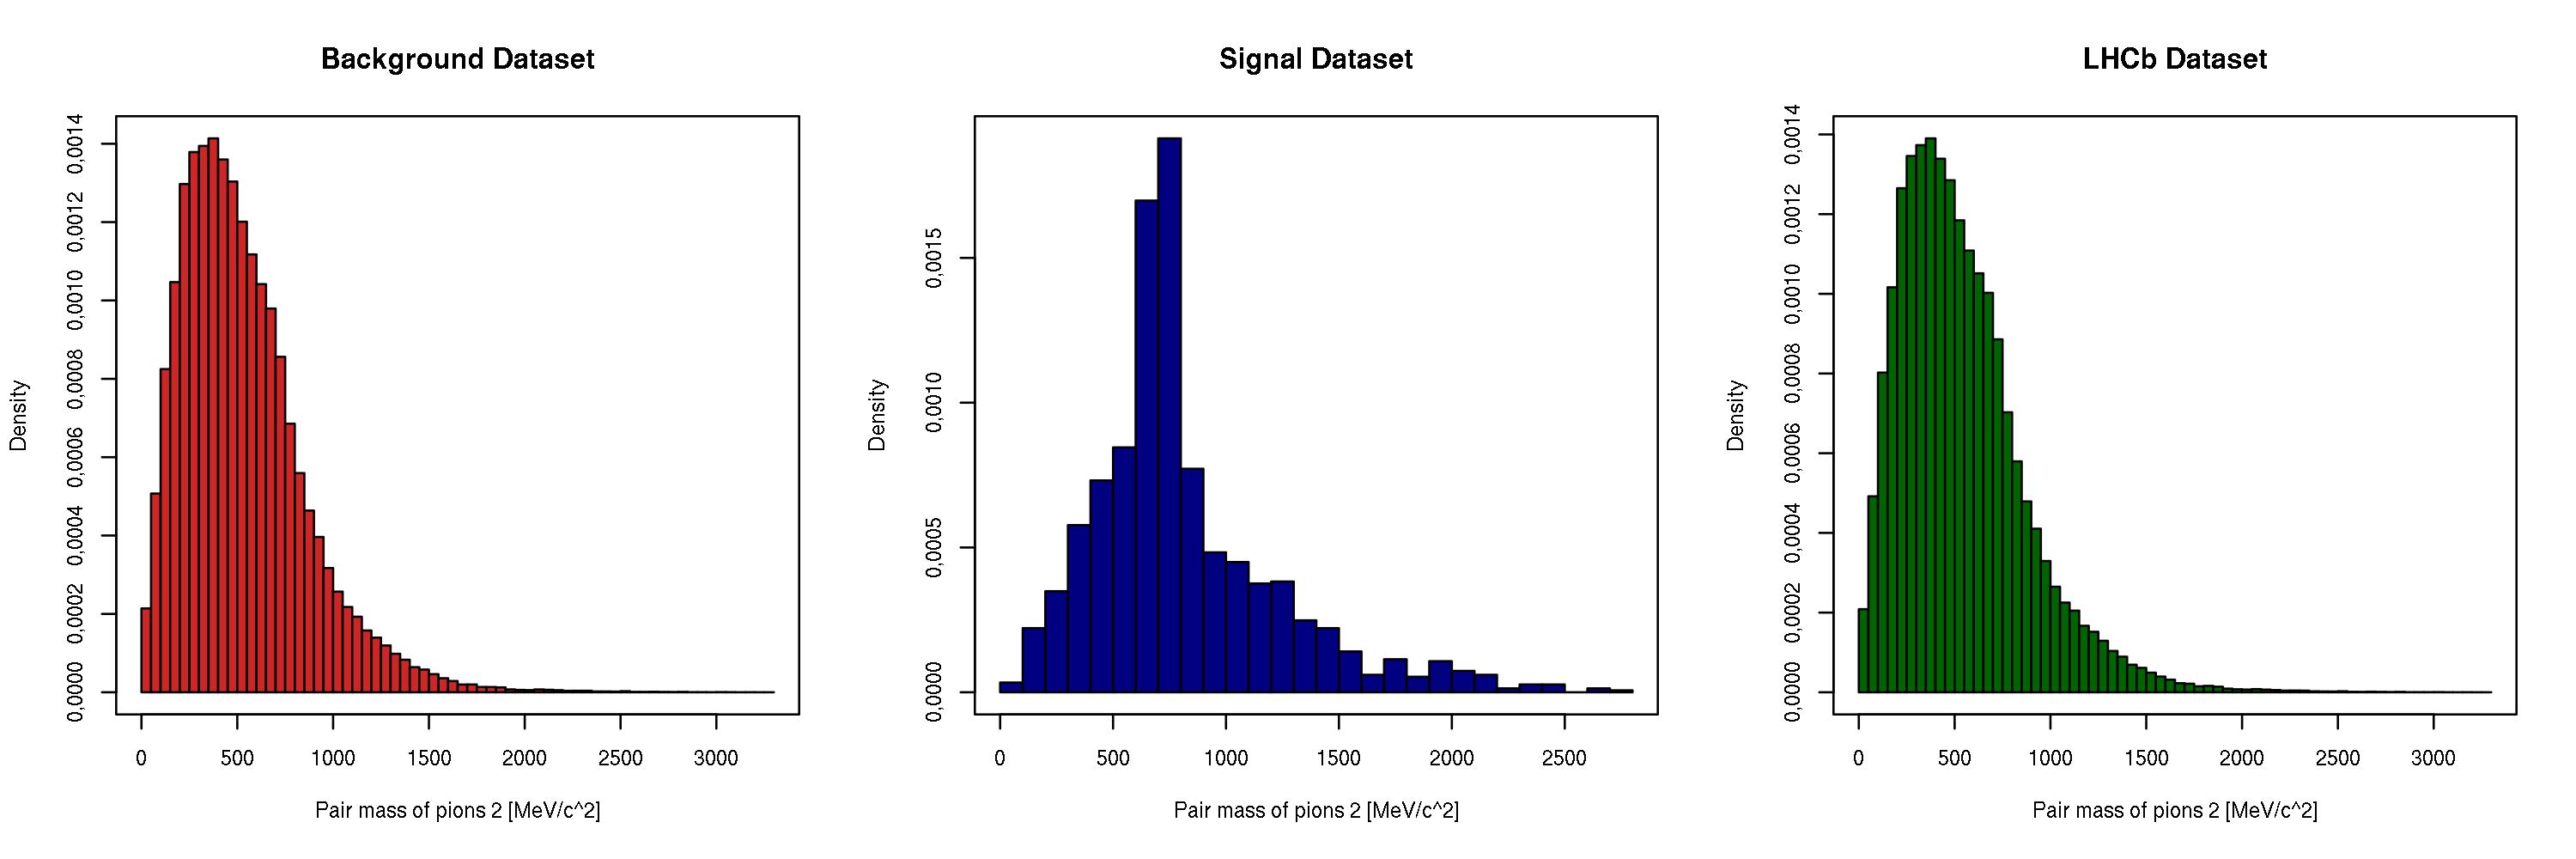

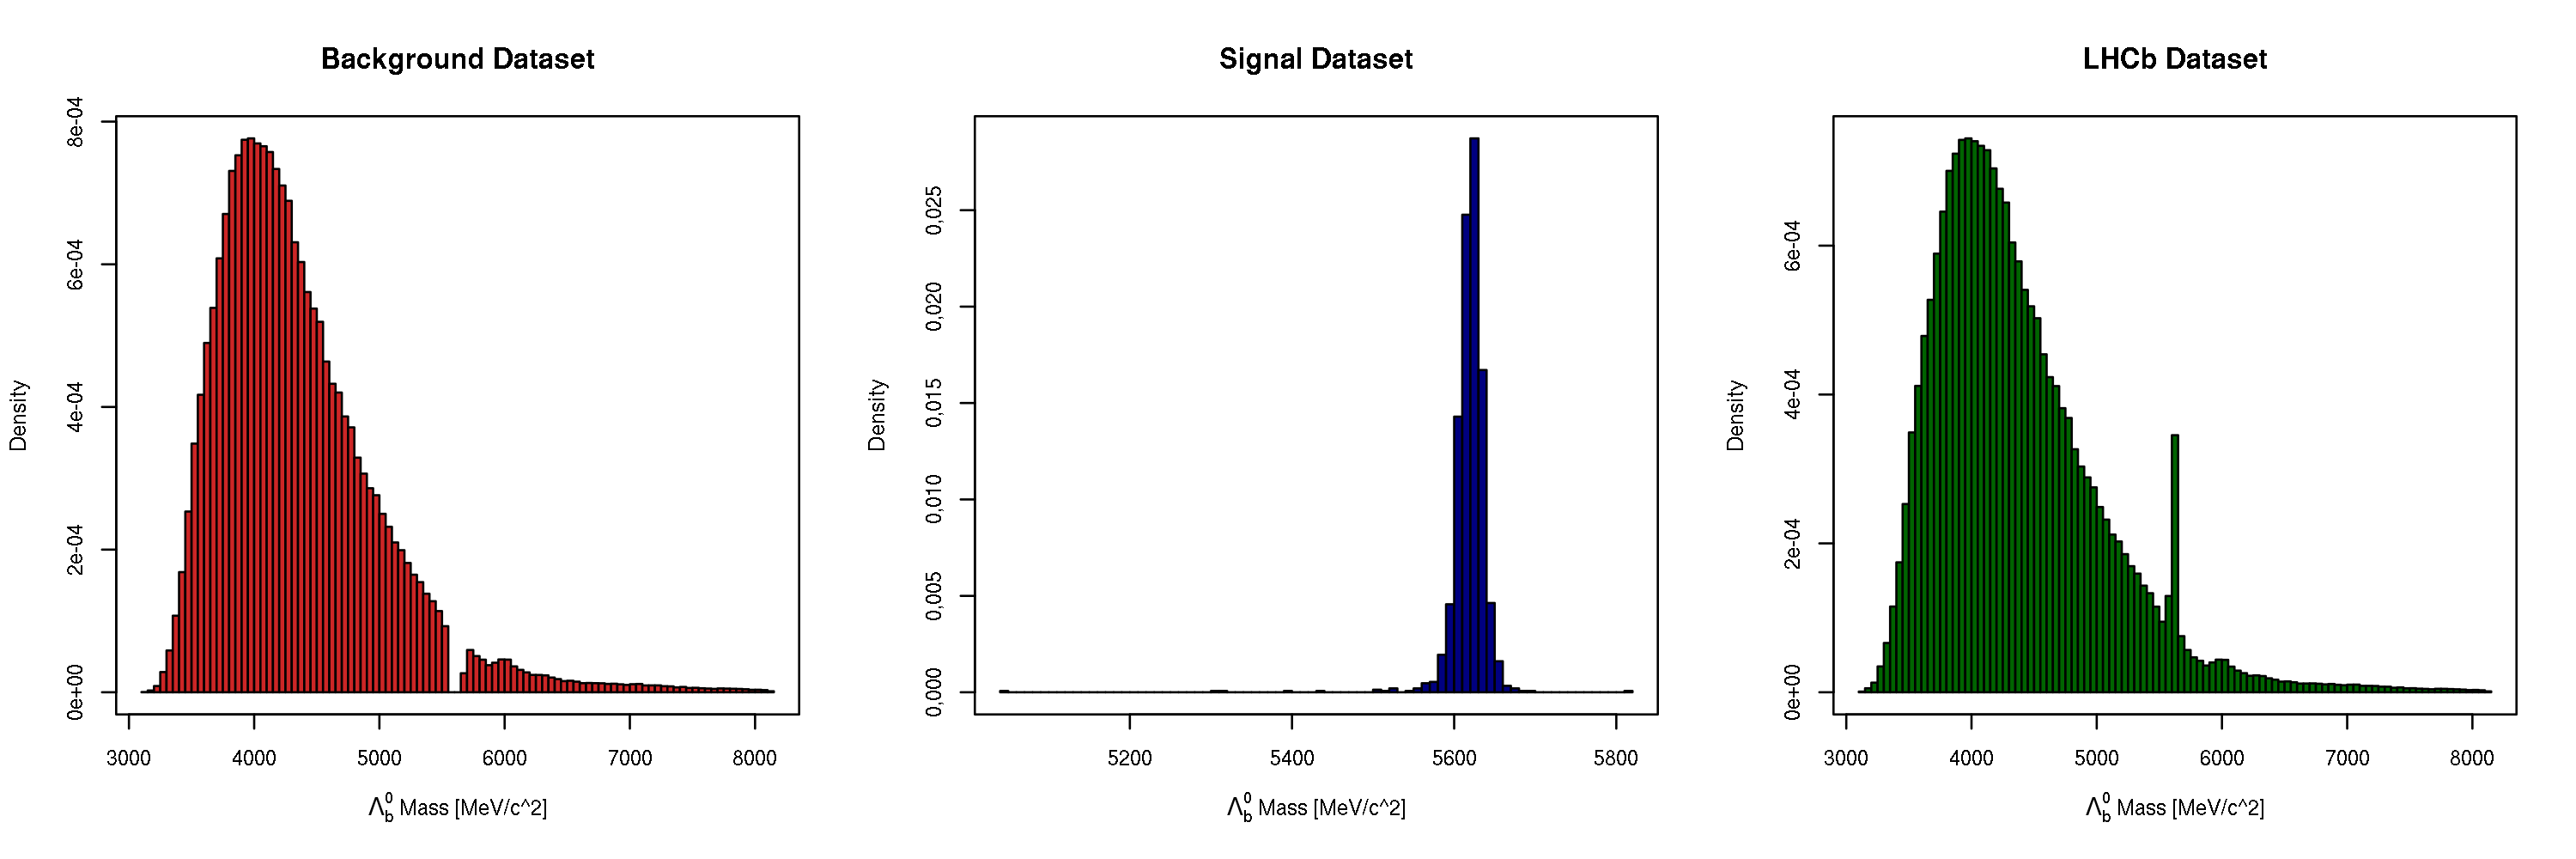

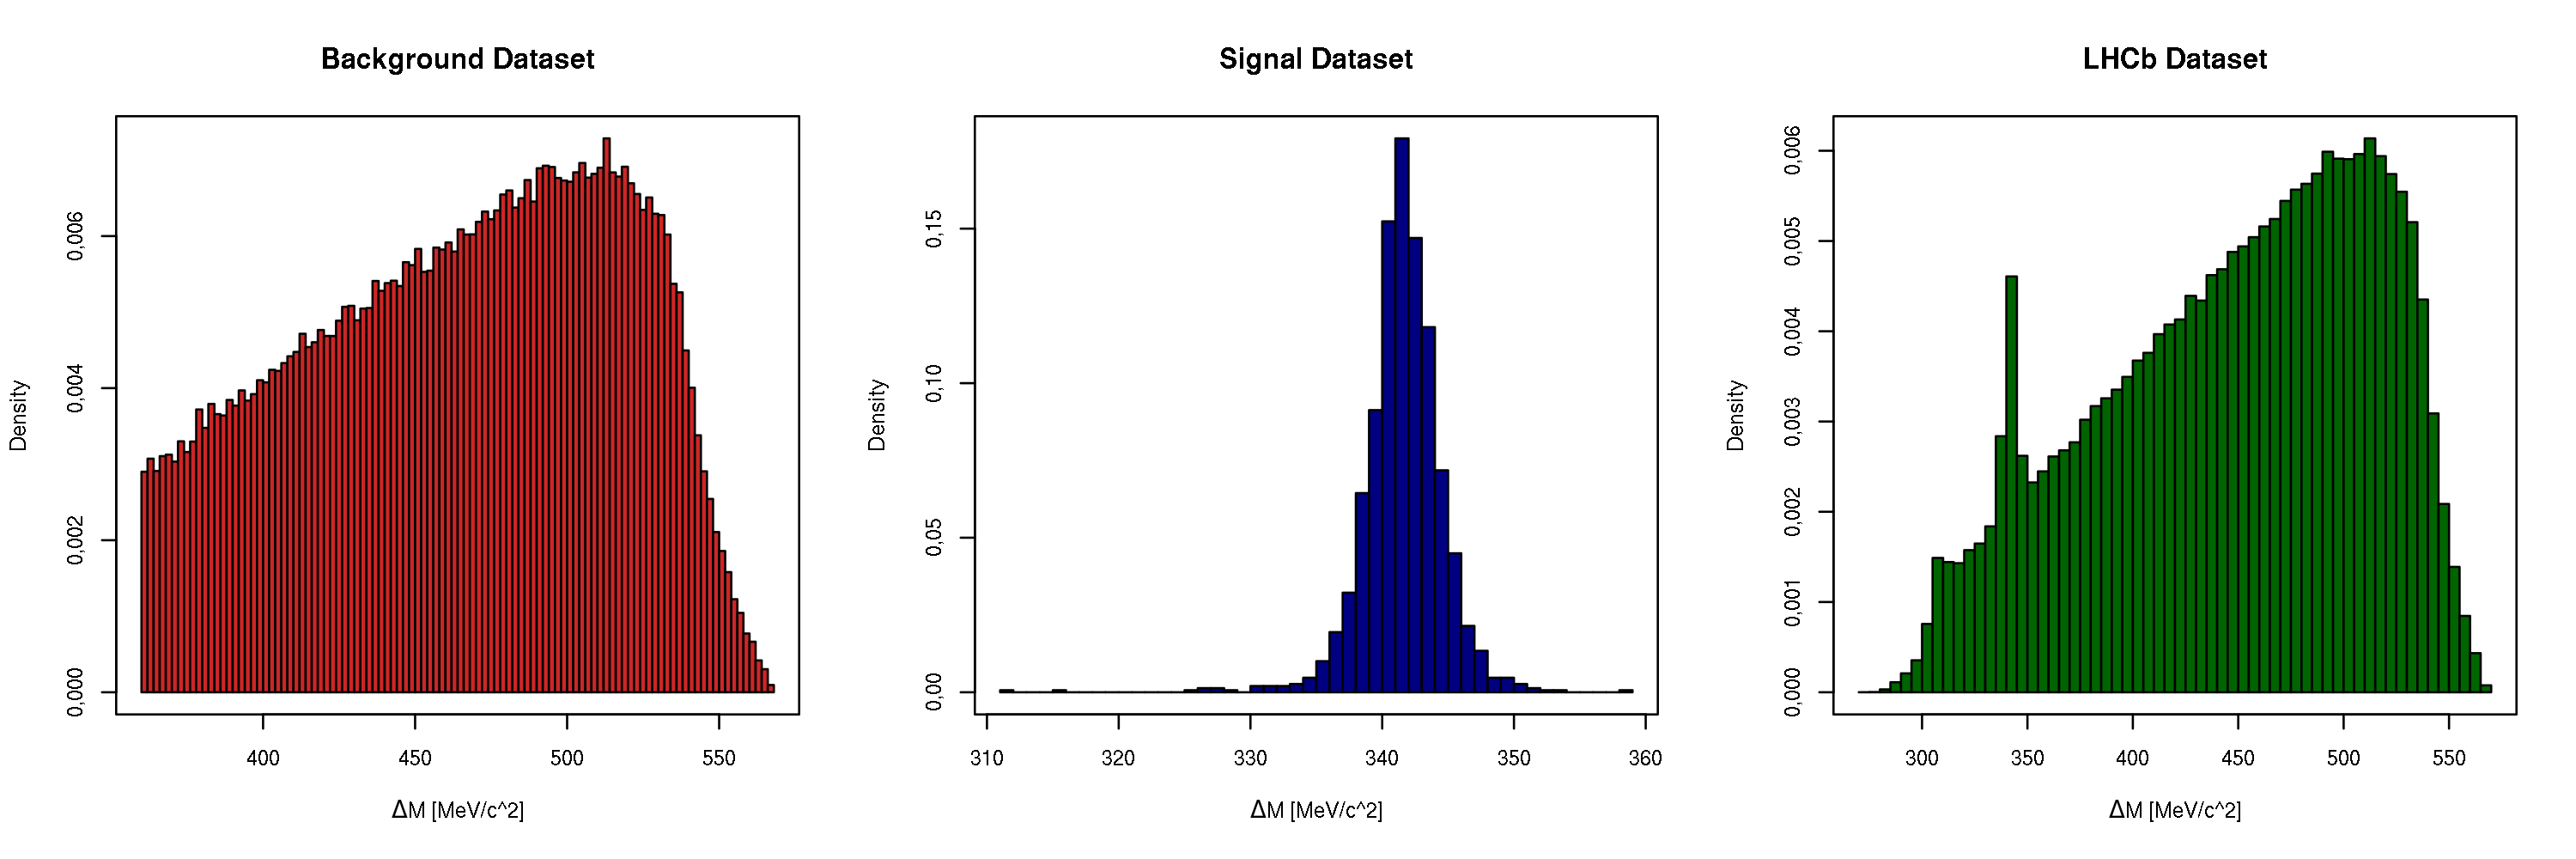

In [8]:
plot_all_input_features()
plot_all_cutting_features()

## Signal estimation

Using a linear fitter in the signal region we estimated the expected background in the signal region in the lhcb dataset and as consequances the expected signal

In [9]:
plot_signal_estimation <- function(repr_plot_width=12, repr_plot_height=4, repr_plot_res=250,
                                  min = 5100, max = 5800, nb = 180) {

    data.lhcb.preSig <- data.lhcb$Lambda_b0_MM_F[data.lhcb$Lambda_b0_MM_F <5550 | data.lhcb$Lambda_b0_MM_F >5680]
    data.lhcb.preSig <- data.lhcb.preSig[data.lhcb.preSig>min & data.lhcb.preSig<max]

    h1<-hist(data.lhcb.preSig, breaks=nb, col="firebrick3",  xlab=expression(paste(Lambda[b]^0, " Mass")), main="LHCb data")
    box()
    temp <- data.frame(x=h1$mids[h1$count!=0], y=h1$counts[h1$count!=0])
    mod <- lm(y~x, data = temp )

    q <-as.numeric(mod[1]$coefficients[1])
    m <-as.numeric(mod[1]$coefficients[2])

    lines(temp$x, temp$x*m+q, col='darkgreen', lwd=5)
    midSig <- h1$mid[h1$counts==0]
    expected_bkg <- sum(midSig*m+q)
    expected_sig <- as.integer(length(data.lhcb$Lambda_b0_MM_F[
                                      data.lhcb$Lambda_b0_MM_F >5550 &
                                      data.lhcb$Lambda_b0_MM_F <5680]) - expected_bkg)
    return(expected_sig)
}

[1] "Signal expected:  7330"


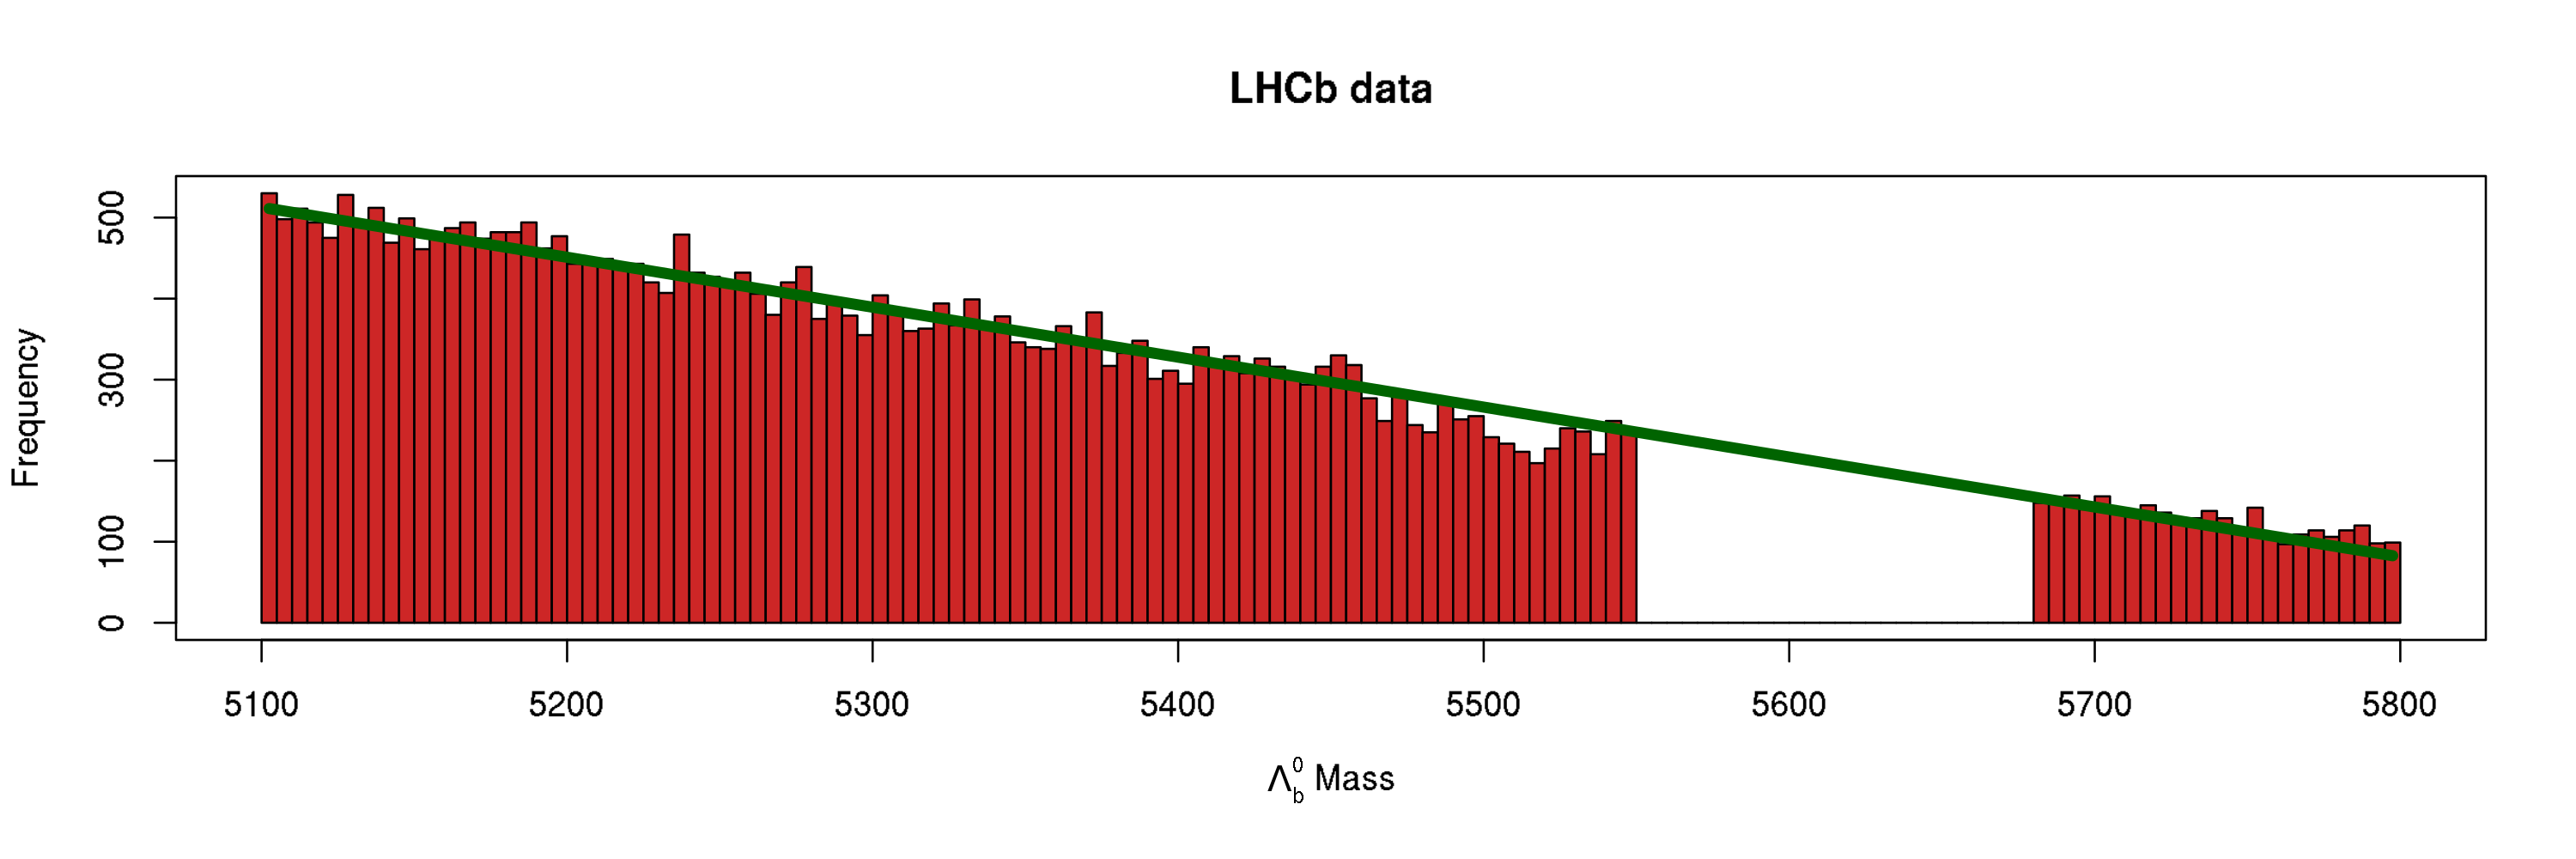

In [10]:
print(paste("Signal expected: ", plot_signal_estimation()))

## Model definition and tuning
In this section we wrote a wrapper for the keras training function in order to implemet a crossvalidation grid search for the hyperparameters tuning, the function responsible for this operation are defined below, these function requires a builder for a keras model to be provided alongside with a flag list of default parameters and a list of parameters on whose the grid search has to be performed

In [11]:
cv_tune_builder <- function (builder, params, x, y, cv=4, name="Test"){
    l=as.integer(nrow(x)/cv)
    accs <- NULL
    for(i in 0:(cv-1)){
        x_tr <- x[-(i*l+1):-(l*(i+1)),]; x_cv <- x[(i*l+1):(l*(i+1)),]; 
        y_tr <- y[-(i*l+1):-(l*(i+1)) ]; y_cv <- y[(i*l+1):(l*(i+1)) ];
        model <- builder(params)
        eph    = ifelse('epochs'     %in% names(params), params$epochs     , 30  )
        b_size = ifelse('batch_size' %in% names(params), params$batch_size , 10 )
        hist  <- model %>% fit (x_tr, y_tr,  epochs = eph, batch_size = b_size, validation_data = list(x_cv, y_cv))
        stats <- model %>% evaluate(x_test, y_test)
        accs <- c(accs, stats[[2]])
        mName <- paste(name, "_cv",i,".hdf5", sep="")
        save_model_hdf5(model, mName)
    }
    return (accs)
}


tune_builder <- function(builder, par_default, par_list, cv=4, verbose=FALSE, path="Models/Test/"){
    if(!dir.exists(path)){
        dir.create(path)
    }
    grid = expand.grid(par_list)
    mean_accs <- NULL
    best_acc <- 0.0
    par_best <- rlang::duplicate(par_default, shallow=FALSE)
    for(i in 1:nrow(grid)){
        par_copy <- rlang::duplicate(par_default, shallow=FALSE)
        mName <- "Model"
        for (name in names(par_list)){
            par_copy[[name]] <- grid[[name]][i]
            mName <- paste(mName,"_",name, grid[[name]][i], sep="")
        }
        data <- get_train_data(par_copy$n_bkg, par_copy$n_sig) #get dataset
        x <- data$x_train; y<-data$y_train;
        acc <- cv_tune_builder(builder, par_copy, x, y, cv, paste(path,mName, sep=""))
        mean_accs <- c(mean_accs, mean(acc))
        if(verbose){
            print("Parameters: ")
            print(par_copy)
            print("Accuracies:")
            print(acc)
            print(paste("Mean: ", mean(acc)))
        }
        if (mean(acc)>best_acc){
            best_acc <- mean(acc)
            par_best <- rlang::duplicate(par_copy, shallow=FALSE)
        }        
    }
    if(verbose){
        print("Best Parameters: ")
        print(par_best)
        print(paste("Accuracy:", best_acc))
    }
    grid$Mean_acc <- mean_accs
    #return(par_best)
    return (grid)
}

In order to use this function we defined a builder function alongside with its default paramters and a function for the optimizer definition:

In [12]:
getOptimizer <- function (params){
    if (params$optimizer == "rmsprop"){
        return (optimizer_rmsprop(lr = params$lr, rho=params$rho))}
    if (params$optimizer == "adam"){
        return (optimizer_adam(lr = params$lr, beta_1 = params$beta_1, 
                                               beta_2 = params$beta_2 ))}
    if (params$optimizer == "nadam"){
        return (optimizer_nadam(lr = params$lr, beta_1 = params$beta_1, 
                                                beta_2 = params$beta_2 ))}
    if (params$optimizer == "sgd"){
        return (optimizer_sgd(lr = params$lr, momentum = params$momentum, 
                               decay = 1e-6, nesterov = TRUE)) }
}

#builder with full params choice
Archi_build_model <- function(params){
    model <- keras_model_sequential()
    model %>%
      layer_dense(units = params$unit1, activation = params$act_dense, 
                  input_shape = c(params$nFeat), 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout1) %>%
      layer_dense(units = params$unit2, activation = params$act_dense,  
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout2) %>%
      layer_dense(units = params$unit3, activation = params$act_dense, 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout3) %>%
      layer_dense(units = 1, activation = params$act_final)

    model %>% compile(
      loss = params$loss,
      optimizer = getOptimizer(params),
      metrics = c('accuracy')
    )
    return(model)
}

In this notebook we will one show a little grid search in the cell below, many of the grid searches perfomed are collected In this notebook  [**here**](https://github.com/mastrovalentz/Adv_Stat_Final_Project/blob/master/Model_Tuner.ipynb), at the following links are also reportd all the model builder functions [**here**](https://github.com/mastrovalentz/Adv_Stat_Final_Project/blob/master/code/ModelBuilder.R) and all the default parameters used
[**here**](https://github.com/mastrovalentz/Adv_Stat_Final_Project/blob/master/code/ModelParameters.R). All the models generated are, in case of need, saved [**here**](https://github.com/mastrovalentz/Adv_Stat_Final_Project/Models/)


In [13]:
ArchiParams_RMS <- flags(
    flag_numeric("dropout1"   , 0.3                   ),
    flag_numeric("dropout2"   , 0.3                   ),
    flag_numeric("dropout3"   , 0.1                   ),
    flag_numeric("unit1"      , 64                    ),
    flag_numeric("unit2"      , 128                   ),
    flag_numeric("unit3"      , 32                    ),
    flag_numeric("nFeat"      , length(sel_features)  ),
    flag_numeric("l1_coeff"   , 1e-5                  ),
    flag_numeric("l2_coeff"   , 1e-4                  ),
    flag_string ("epochs"     , 5                     ),  
    flag_string ("batch_size" , 10                    ),
    flag_numeric("n_bkg"      , 1000                  ),
    flag_numeric("n_sig"      , 1090                  ),
    flag_string ("act_dense"  , "relu"                ),
    flag_string ("act_final"  , "hard_sigmoid"        ),
    flag_string ("loss"       , "binary_crossentropy" ),
    flag_string ("optimizer"  , "rmsprop"             ),
    flag_numeric("lr"         , 0.003                 ), #learing rate for the optimizers
    flag_numeric("rho"        , 0.9                   ), #rms rho
    flag_numeric("beta_1"     , 0.9                   ), #beta1 adam/nadam
    flag_numeric("beta_2"     , 0.999                 ), #beta2 adam/nadam
    flag_numeric("momentum"   , 0.9                   ) #momentum sgd
)



Batch_Epoch_List <- list(batch_size=c( 20, 50), 
               epochs=c(3,5))
tuned_grid <- tune_builder(Archi_build_model, ArchiParams_RMS, Batch_Epoch_List, 4, FALSE, "../Models/Batch_Epoch/" )
print(tuned_grid)

  batch_size epochs  Mean_acc
1         20      3 0,8359375
2         50      3 0,8303125
3         20      5 0,8396875
4         50      5 0,8343750


## Results visualization and analysis

In order to visualize the results of the network we defined two functions which given an array of thresholds respectivelt draw the Model prediction for each of this and perform a numerical analysis of the classification.

In [14]:
drawPrediction <- function(builder, params, prob, cols, repr_plot_width=16, repr_plot_height=8, repr_plot_res=150){
    model <- builder(params)
    data  <- get_train_data(params$n_bkg)
    history  <- model %>% fit (data$x_train, data$y_train, verbose=0,
                     epochs=params$epochs, batch_size=params$batch_size, validation_split=0.2)
    y_cut_lhcb_pred <- model %>% predict(x_cut_lhcb)
    y_lhcb_pred     <- model %>% predict(x_lhcb)
    par(mfrow=c(1,2))
    options(repr.plot.width=repr_plot_width, repr.plot.height=repr_plot_height, repr.plot.res=repr_plot_res)
    hist(data.lhcb$Lambda_b0_MM_F[y_lhcb_pred>=0.0], breaks=100, col="blue", xlab=expression(paste(Lambda[b]^0, " Mass", " [MeV/c^2]")), main="LHCb Dataset",  probability=FALSE)
	box()
    for(i in 1:length(prob)){
        hist(data.lhcb$Lambda_b0_MM_F[y_lhcb_pred>prob[i]],   breaks=100, col=cols[i], add=TRUE)
    }
    legend(6000, 13000, legend=c(paste("Optimizer: ", params$optimizer),"Full Dataset", paste("Threshold =",prob)),
           fill=c("white", "blue", cols), border="white", bty='n', x.intersp = 0.5)
    hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>=0.0], breaks=100, col="blue", xlab=expression(paste(Lambda[b]^0, " Mass", " [MeV/c^2]")), main="LHCb Cutted Dataset",  probability=FALSE)
	box()
    for(i in 1:length(prob)){
        hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>prob[i]],   breaks=100, col=cols[i], add=TRUE)
    }
    legend(6000,6000, legend=c(paste("Optimizer: ", params$optimizer),"Cutted Dataset", paste("Threshold =",prob)),
           fill=c("white", "blue",cols), border="white", bty='n', x.intersp = 0.5)
}

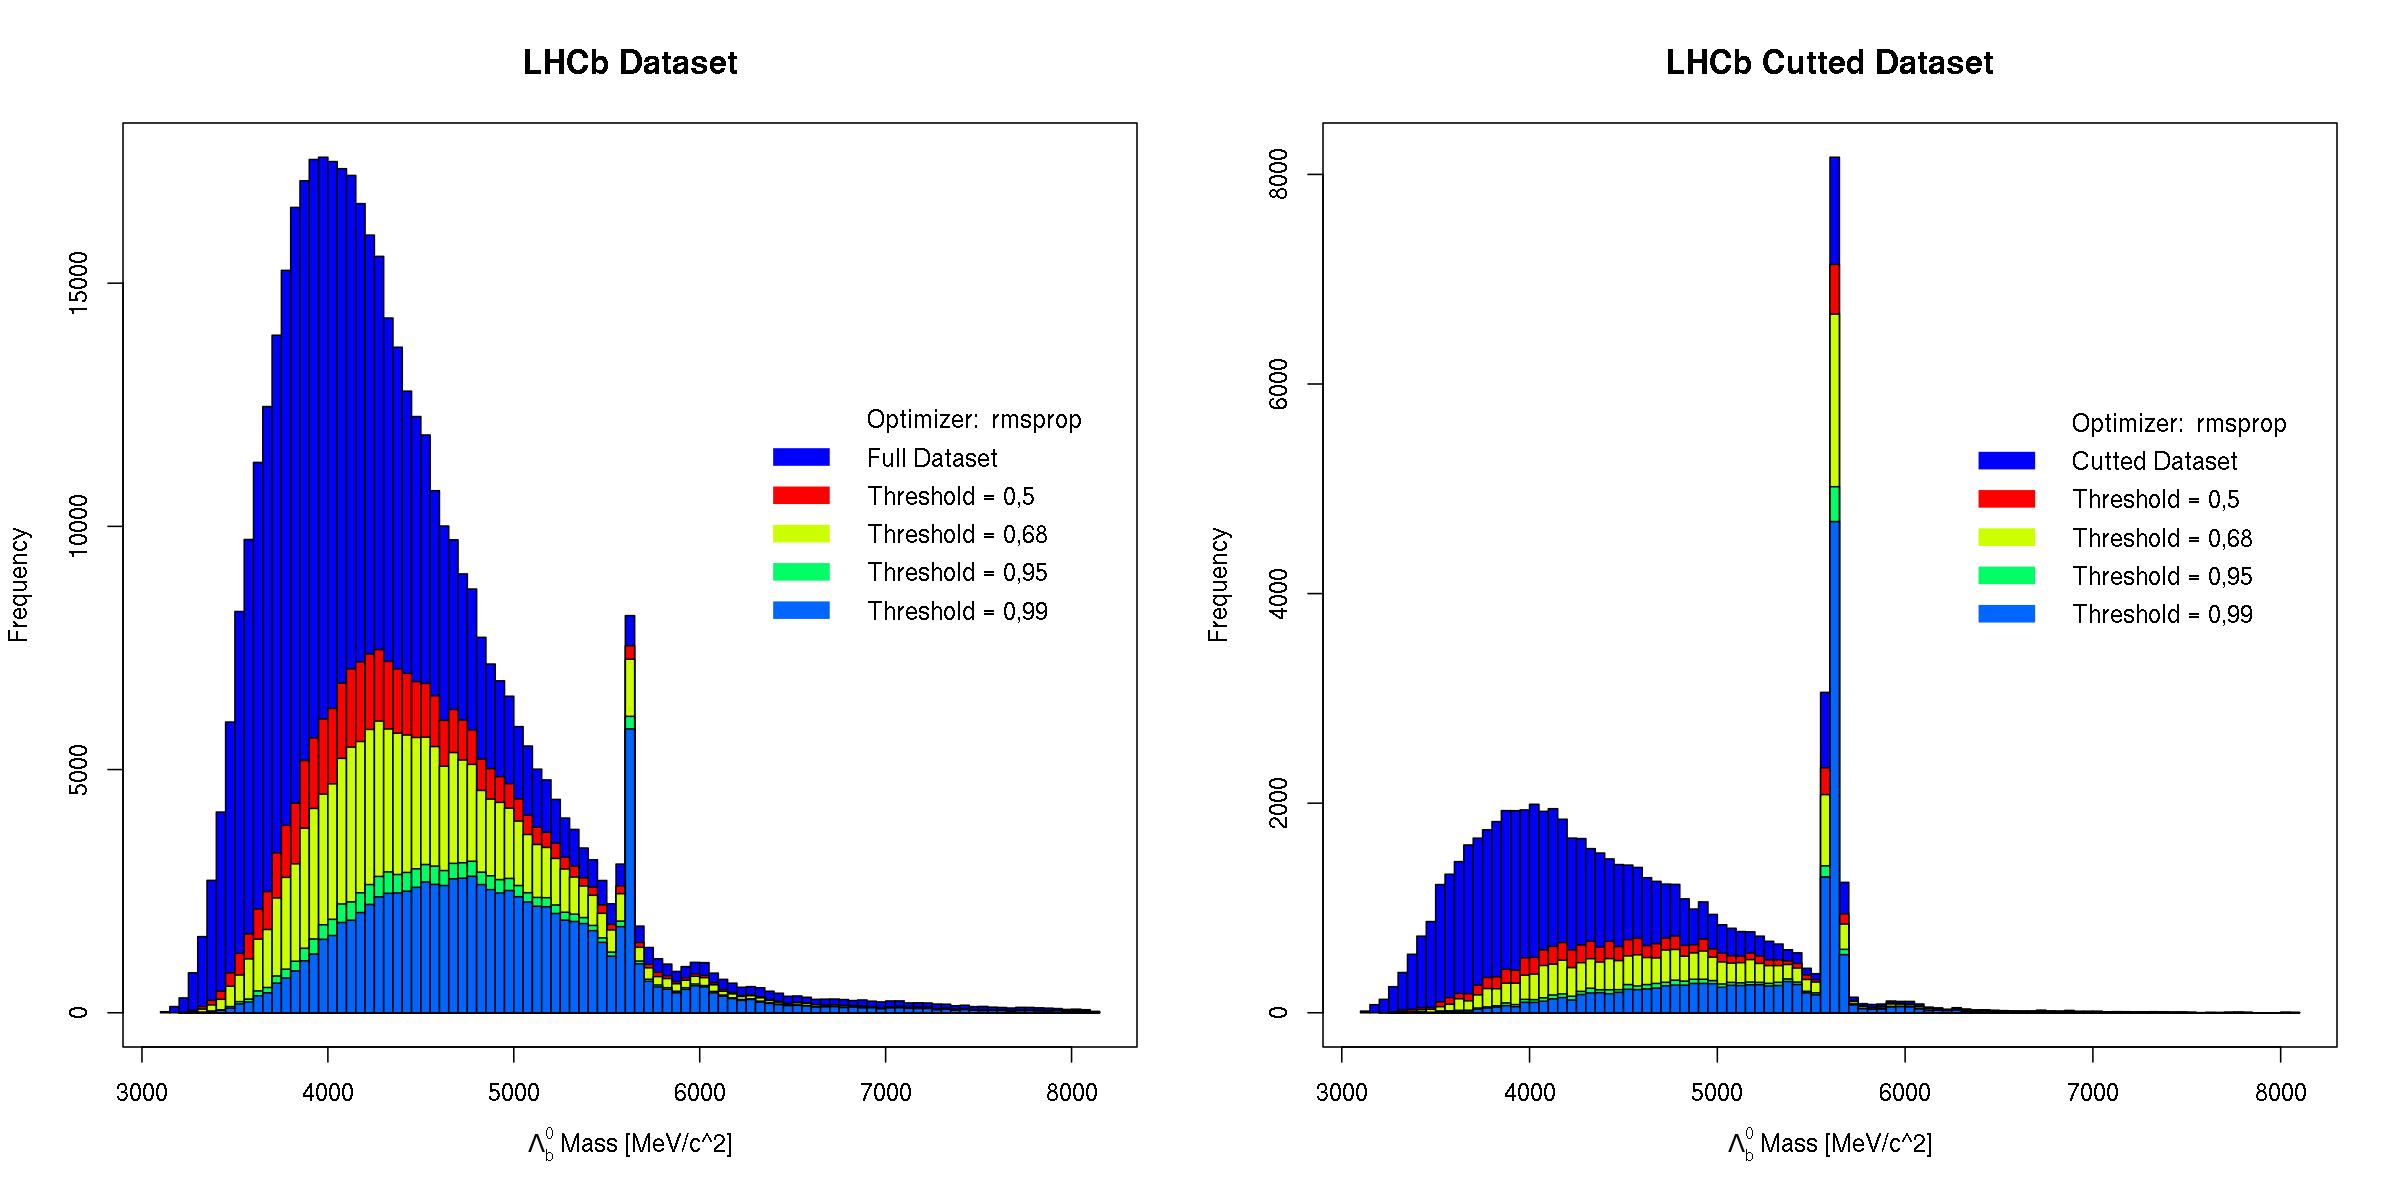

In [15]:
drawPrediction(Archi_build_model, ArchiParams_RMS, c(0.5, 0.68, 0.95, 0.99), rainbow(5))

The follwing function performs a numerical analysis, in order to speed up the cmoputation we defined also 4 vectorized function which are responsible for the computation of Signal and False Signal numer in the full and Cutted LHCb dataset

In [16]:
Sig_expect <- 7330

len_sig      <- Vectorize(function(pred, p){
    length(data.lhcb$Lambda_b0_MM_F[data.lhcb$Lambda_b0_MM_F>5550 & data.lhcb$Lambda_b0_MM_F<5680 & pred>=p]) }, vectorize.args = 'p')
len_sig_cut  <- Vectorize(function(pred, p){
    length(data.cutted.lhcb$Lambda_b0_MM_F[data.cutted.lhcb$Lambda_b0_MM_F>5550 & 
                            data.cutted.lhcb$Lambda_b0_MM_F<5680 & pred>=p]) }, , vectorize.args = 'p')

len_sig_false      <- Vectorize(function(pred, p){
    length(data.lhcb$Lambda_b0_MM_F[(data.lhcb$Lambda_b0_MM_F<5550 | data.lhcb$Lambda_b0_MM_F>5680) & pred>=p]) }, vectorize.args = 'p')
len_sig_false_cut  <- Vectorize(function(pred, p){
    length(data.cutted.lhcb$Lambda_b0_MM_F[(data.cutted.lhcb$Lambda_b0_MM_F>5550 | 
                            data.cutted.lhcb$Lambda_b0_MM_F>5680) & pred>=p]) }, , vectorize.args = 'p')

PredictionAnalysis <- function(builder, params, prob){
    model <- builder(params)
    data  <- get_train_data(params$n_bkg) 
    history  <- model %>% fit (data$x_train, data$y_train, verbose=0,
                     epochs=params$epochs, batch_size=params$batch_size, validation_split=0.2)
    y_cut_lhcb_pred <- model %>% predict(x_cut_lhcb)
    y_lhcb_pred     <- model %>% predict(x_lhcb)
    ntot     <- length(data.lhcb$Lambda_b0_MM_F)
    ntot_cut <- length(data.cutted.lhcb$Lambda_b0_MM_F)
    nsig     <- len_sig    (y_lhcb_pred     ,prob) 
    nsig_cut <- len_sig_cut(y_cut_lhcb_pred ,prob)
    nsig_false     <- len_sig_false    (y_lhcb_pred     ,prob) 
    nsig_false_cut <- len_sig_false_cut(y_cut_lhcb_pred ,prob)

    nbkg     <- ntot     - nsig     -  nsig_false    
    nbkg_cut <- ntot_cut - nsig_cut -  nsig_false_cut
    lost_sig     <- (Sig_expect -nsig    ) / Sig_expect  #signal not detected
    lost_sig_cut <- (Sig_expect -nsig_cut) / Sig_expect  #signal not detected
    miss_Bkg     <- nsig_false     / (ntot     - Sig_expect)  #missclassified bkg
    miss_Bkg_cut <- nsig_false_cut / (ntot_cut - Sig_expect)  #missclassified bkg
    
    result <- data.frame(prob=prob, nSig   =nsig    , nBkg   =nbkg,     LostSig   =lost_sig,     FalseSig   =miss_Bkg,
                                    nSigCut=nsig_cut, nBkgCut=nbkg_cut, LostSigCut=lost_sig_cut, FalseSigCut=miss_Bkg_cut)
    return (result)
}

In [17]:
PredictionAnalysis(Archi_build_model, ArchiParams_RMS, c(0.5, 0.68, 0.95, 0.99))

prob,nSig,nBkg,LostSig,FalseSig,nSigCut,nBkgCut,LostSigCut,FalseSigCut
"0,50",11620,182819,"-0,5852660","0,5979782",11171,46022,"-0,5240109","0,1991423"
"0,68",11082,224158,"-0,5118690","0,5103133",10426,47620,"-0,4223738","0,1854422"
"0,95",9860,294470,"-0,3451569","0,3618667",8918,50842,"-0,2166439","0,1579133"
"0,99",9653,305689,"-0,3169168","0,3382064",8620,51480,"-0,1759891","0,1524525"
